**Rozdział 11. Uczenie głębokie**

_Notatnik ten zawiera przykładowy kod i rozwiązania ćwiczeń opisane w rozdziale 11._

# Konfiguracja

Upewnijmy się najpierw, że notatnik ten będzie działał w środowiskach Python 2 i 3, importujmy kilka powszechnie stosowanych modułów, upewnijmy się, że moduł MatplotLib będzie prawidłowo tworzył wykresy, a także przygotujmy funkcję zapisującą rysunki:

In [1]:
# Obsługa środowisk Python 2 i Python 3
from __future__ import division, print_function, unicode_literals

# Importowanie popularnych modułów
import numpy as np
import os

# W celu zachowania powtarzalności wyników w kolejnych przebiegach
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Generowanie ładnych wykresów
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Lokacja, w której będą zapisywane rysunki
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "glebokie"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "rysunki", CHAPTER_ID, fig_id + ".png")
    print("Zapisywanie rysunku", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Problem zanikających/eksplodujących gradientów

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Zapisywanie rysunku wykres_nasycenia_funkcji_sigmoidalnej


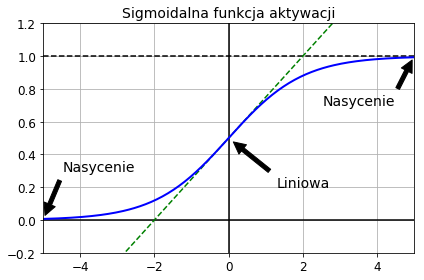

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Nasycenie', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Nasycenie', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Liniowa', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoidalna funkcja aktywacji", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("wykres_nasycenia_funkcji_sigmoidalnej")
plt.show()

## Inicjacja Xaviera i He'ego

Uwaga: w książce wykorzystywana jest funkcja `tensorflow.contrib.layers.fully_connected()` zamiast funkcji `tf.layers.dense()` (która jeszcze nie istniała w czasie pisania rozdziału). Obecnie zalecane jest używanie funkcji `tf.layers.dense()`, ponieważ wszelkie elementy modułu `contrib` mogą być modyfikowane lub usuwane bez zapowiedzi. Funkcja `dense()` jest niemal identyczna jak funkcja `fully_connected()`, cechuje je jednak kilka pomniejszych różnic:
* zmianie uległy nazwy kilku parametrów: `scope` został zmieniony na `name`, `activation_fn` staje się `activation` (w analogiczny sposób został usunięty przyrostek `_fn` z innych parametrów, takich jak `normalizer_fn`), `weights_initializer` jest przemianowany na `kernel_initializer` itd.,
* domyślną wartością parametru `activation` jest teraz `None`, a nie `tf.nn.relu`,
* nie jest obsługiwana funkcja `tensorflow.contrib.framework.arg_scope()` (opisana w dalszej części rozdziału 11.),
* nie są obsługiwane parametry regularyztora (opisane w dalszej części rozdziału 11.).

In [4]:
import tensorflow as tf

In [5]:
reset_graph()

n_inputs = 28 * 28  # zestaw MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [6]:
he_init = tf.contrib.layers.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="ukryta1")


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


## Nienasycające funkcje aktywacji

### Przeciekająca funkcja ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Zapisywanie rysunku wykres_przeciekającej_funkcji_relu


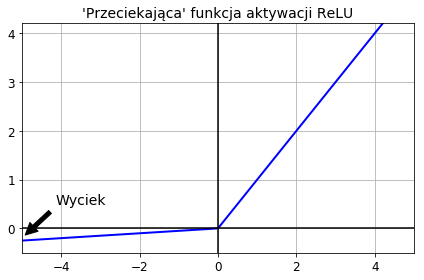

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Wyciek', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("'Przeciekająca' funkcja aktywacji ReLU", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("wykres_przeciekającej_funkcji_relu")
plt.show()

Implementacja przeciekającej funkcji ReLU w module TensorFlow:

In [9]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [10]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="ukryta1")

Wyuczmy sieć neuronową wobec zbioru danych MNIST wykorzystując przeciekającą funkcję ReLU. Najpierw stwórzmy graf:

In [11]:
reset_graph()

n_inputs = 28 * 28  # zestaw MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [12]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [13]:
with tf.name_scope("gsn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="ukryta1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="ukryta2")
    logits = tf.layers.dense(hidden2, n_outputs, name="wyjscia")

In [14]:
with tf.name_scope("strata"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="strata")

In [15]:
learning_rate = 0.01

with tf.name_scope("uczenie"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [16]:
with tf.name_scope("ocena"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [17]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Wczytajmy teraz dane:

In [18]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/dane/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/dane/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/dane/train-labels-idx1-ubyte.gz
Extracting /tmp/dane/t10k-images-idx3-ubyte.gz
Extracting /tmp/dane/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [19]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_test = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
            print(epoch, "Dokładność: dla mini-grupy", acc_train, "dla zestawu walidacyjnego", acc_test)

    save_path = saver.save(sess, "./moj_model_ostateczny.ckpt")

0 Dokładność: dla mini-grupy 0.86 dla zestawu walidacyjnego 0.9044
5 Dokładność: dla mini-grupy 0.94 dla zestawu walidacyjnego 0.9512
10 Dokładność: dla mini-grupy 0.96 dla zestawu walidacyjnego 0.9662
15 Dokładność: dla mini-grupy 1.0 dla zestawu walidacyjnego 0.9722
20 Dokładność: dla mini-grupy 1.0 dla zestawu walidacyjnego 0.9744
25 Dokładność: dla mini-grupy 1.0 dla zestawu walidacyjnego 0.9766
30 Dokładność: dla mini-grupy 1.0 dla zestawu walidacyjnego 0.9778
35 Dokładność: dla mini-grupy 0.96 dla zestawu walidacyjnego 0.9794


### Funkcja ELU

In [20]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Zapisywanie rysunku wykres_funkcji_elu


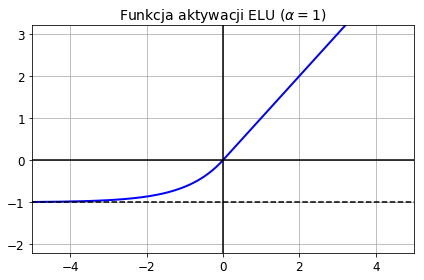

In [21]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"Funkcja aktywacji ELU ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("wykres_funkcji_elu")
plt.show()

Implementacja funkcji ELU w module TensorFlow jest banalna; wystarczy określić funkcję aktywacji podczas tworzenia każdej warstwy:

In [22]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [23]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="ukryta1")

### Funkcja SELU

Ta funkcja aktywacji została opisana w tej [znakomitej publikacji](https://arxiv.org/pdf/1706.02515.pdf) autorstwa Güntera Klambauera, Thomasa Unterthinera i Andreasa Mayra, która ukazała się w czerwcu 2017 roku (zamierzam o niej wspomnieć w kolejnych wydaniach książki). Osiąga ona znacznie lepsze wyniki od pozostałych funkcji aktywacji w obszarze głębokich sieci neuronowych, dlatego naprawdę warto ją wypróbować.

In [24]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

Zapisywanie rysunku wykres_funkcji_selu


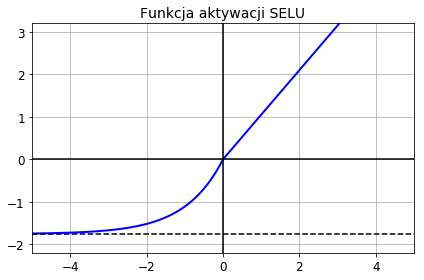

In [25]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"Funkcja aktywacji SELU", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("wykres_funkcji_selu")
plt.show()

Dzięki tej funkcji aktywacji nawet stuwarstwowa głęboka sieć neuronowa zachowuje w przybliżeniu średnią 0 i odchylenie standardowe równe 1 we wszystkich warstwach, co pozwala uniknąć problemu zanikających/eksplodujących gradientów:

In [26]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("Warstwa {}: {:.2f} < średnia < {:.2f}, {:.2f} < odchylenie standardowe < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

Warstwa 0: -0.26 < średnia < 0.27, 0.74 < odchylenie standardowe < 1.27
Warstwa 10: -0.24 < średnia < 0.27, 0.74 < odchylenie standardowe < 1.27
Warstwa 20: -0.17 < średnia < 0.18, 0.74 < odchylenie standardowe < 1.24
Warstwa 30: -0.27 < średnia < 0.24, 0.78 < odchylenie standardowe < 1.20
Warstwa 40: -0.38 < średnia < 0.39, 0.74 < odchylenie standardowe < 1.25
Warstwa 50: -0.27 < średnia < 0.31, 0.73 < odchylenie standardowe < 1.27
Warstwa 60: -0.26 < średnia < 0.43, 0.74 < odchylenie standardowe < 1.35
Warstwa 70: -0.19 < średnia < 0.21, 0.75 < odchylenie standardowe < 1.21
Warstwa 80: -0.18 < średnia < 0.16, 0.72 < odchylenie standardowe < 1.19
Warstwa 90: -0.19 < średnia < 0.16, 0.75 < odchylenie standardowe < 1.20


Poniżej przedstawiam implementację w module TensorFlow (niemal z pewnością w przyszłych wersjach tejże biblioteki zostanie wstawiona funkcja `tf.nn.selu()`):

In [27]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

Funkcje SELU mogą być również łączone z metodą porzucania; sprawdź [tę implementację](https://github.com/bioinf-jku/SNNs/blob/master/selu.py) stworzoną w instytucie bioinformatyki na Uniwersytecie Johannesa Keplera w Linz.

Stwórzmy sieć neuronową dla zestawu danych MNIST, wykorzystującą funkcję aktywacji SELU:

In [28]:
reset_graph()

n_inputs = 28 * 28  # zestaw MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("gsn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="ukryta1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="ukryta2")
    logits = tf.layers.dense(hidden2, n_outputs, name="wyjscia")

with tf.name_scope("strata"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="strata")

learning_rate = 0.01

with tf.name_scope("uczenie"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("ocena"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

Wytrenujmy ją teraz. Nie zapomnijmy przeskalować danych wejściowych do średniej równej 0 i odchylenia standardowego równego 1: 

In [29]:
means = mnist.train.images.mean(axis=0, keepdims=True)
stds = mnist.train.images.std(axis=0, keepdims=True) + 1e-10

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            X_val_scaled = (mnist.validation.images - means) / stds
            acc_test = accuracy.eval(feed_dict={X: X_val_scaled, y: mnist.validation.labels})
            print(epoch, "Dokładność: dla mini-grupy", acc_train, "dla zbioru walidacyjnego:", acc_test)

    save_path = saver.save(sess, "./moj_model_ostateczny_selu.ckpt")

0 Dokładność: dla mini-grupy 0.96 dla zbioru walidacyjnego: 0.924
5 Dokładność: dla mini-grupy 1.0 dla zbioru walidacyjnego: 0.9566
10 Dokładność: dla mini-grupy 0.94 dla zbioru walidacyjnego: 0.967
15 Dokładność: dla mini-grupy 0.98 dla zbioru walidacyjnego: 0.968
20 Dokładność: dla mini-grupy 1.0 dla zbioru walidacyjnego: 0.971
25 Dokładność: dla mini-grupy 1.0 dla zbioru walidacyjnego: 0.9694
30 Dokładność: dla mini-grupy 1.0 dla zbioru walidacyjnego: 0.97
35 Dokładność: dla mini-grupy 1.0 dla zbioru walidacyjnego: 0.9708


# Normalizacja wsadowa

Uwaga: w książce wykorzystywałem funkcję `tensorflow.contrib.layers.batch_norm()` zamiast funkcji `tf.layers.batch_normalization()` (która jeszcze nie istniała w trakcie pisania tego rozdziału). Obecnie zalecane jest używanie funkcji  `tf.layers.batch_normalization()`, ponieważ wszelkie elementy modułu contrib mogą być modyfikowane lub usuwane bez zapowiedzi. Obecnie nie wykorzystujemy funkcji `batch_norm()` jako parametru regularyzacji funkcji `fully_connected()`, lecz wprowadzamy funkcję `batch_normalization()` i jawnie tworzymy oddzielną warstwę. Parametry różnią się nieznacznie, zwłaszcza:  
* parametr `decay` jest przemianowany na `momentum`,
* parametr `is_training` został przemianowany na `training`,
* parametr `updates_collections` został usunięty: operacje aktualizowania wymagane przez normalizację wsadową znajdują się teraz w kolekcji `UPDATE_OPS`, a my musimy je jawnie uruchamiać w trakcie uczenia (patrz poniższa faza wykonawcza),
* nie musimy wyznaczać wartości `scale=True`, gdyż jest ona domyślna.

Zwróć również uwagę, że w celu przeprowadzenia normalizacji wsadowej tuż _przed_ funkcją aktywacji w każdej warstwie ukrytej, ręcznie wprowadzamy funkcję ELU zaraz za warstwą normalizacji wsadowej.

Uwaga: funkcja `tf.layers.dense()` jest niekompatybilna z funkcją `tf.contrib.layers.arg_scope()` (która jest używana w książce), dlatego zastępuję ją teraz funkcją `functools.partial()`. W ten sposób możemy z łatwością stworzyć funkcję `my_dense_layer()`, której jedynym zadaniem będzie wywoływanie funkcji `tf.layers.dense()` z automatycznie wyznaczonymi pożądanymi wartościami parametrów (chyba że zostają one przesłonięte w trakcie wywoływania funkcji `my_dense_layer()`). Jak widać, sam kod nie ulega większym zmianom.

In [30]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='uczenie')

hidden1 = tf.layers.dense(X, n_hidden1, name="ukryta1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="ukryta2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="wyjscia")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

In [31]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='uczenie')

Aby uniknąć ciągłego powtarzania parametrów, możemy skorzystać z funkcji `partial()`:

In [32]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="ukryta1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="ukryta2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="wyjscia")
logits = my_batch_norm_layer(logits_before_bn)

Stwórzmy teraz sieć neuronową dla zbioru MNIST, wykorzystując funkcję aktywacji ELU i normalizację wsadową w każdej warstwie: 

In [33]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='uczenie')

with tf.name_scope("gsn"):
    he_init = tf.contrib.layers.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="ukryta1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="ukryta2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="wyjscia")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("strata"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="strata")

with tf.name_scope("uczenie"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("ocena"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Uwaga: korzystamy z funkcji `tf.layers.batch_normalization()` zamiast z funkcji `tf.contrib.layers.batch_norm()` (stosowanej w książce), dlatego musimy jawnie uruchomić dodatkowe operacje aktualizacji wymagane przez normalizację wsadową (`sess.run([training_op, extra_update_ops],...`).

In [34]:
n_epochs = 20
batch_size = 200

In [35]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Dokładność dla zbioru testowego:", accuracy_val)

    save_path = saver.save(sess, "./moj_model_ostateczny.ckpt")

0 Dokładność dla zbioru testowego: 0.8721
1 Dokładność dla zbioru testowego: 0.8981
2 Dokładność dla zbioru testowego: 0.9134
3 Dokładność dla zbioru testowego: 0.9238
4 Dokładność dla zbioru testowego: 0.9297
5 Dokładność dla zbioru testowego: 0.9352
6 Dokładność dla zbioru testowego: 0.9405
7 Dokładność dla zbioru testowego: 0.9436
8 Dokładność dla zbioru testowego: 0.947
9 Dokładność dla zbioru testowego: 0.9502
10 Dokładność dla zbioru testowego: 0.9528
11 Dokładność dla zbioru testowego: 0.9549
12 Dokładność dla zbioru testowego: 0.9566
13 Dokładność dla zbioru testowego: 0.9589
14 Dokładność dla zbioru testowego: 0.9602
15 Dokładność dla zbioru testowego: 0.9612
16 Dokładność dla zbioru testowego: 0.962
17 Dokładność dla zbioru testowego: 0.9637
18 Dokładność dla zbioru testowego: 0.9651
19 Dokładność dla zbioru testowego: 0.9656


Co!? To wcale nie jest dobra dokładność dla zbioru MNIST. Oczywiście, jeśli pozwolisz modelowi uczyć się dłużej, uzyska znacznie lepszą dokładność, ale przy tak płytkiej sieci zarówno normalizacja wsadowa, jak i funkcja ELU będą miały niewielki wpływ na wydajność: rozwijają one skrzydła dopiero w znacznie głębszych sieciach neuronowych.

Zwróć uwagę, że moglibyśmy również uzależnić operację uczenia od operacji aktualizowania:

```python
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)
```

W ten sposób wystarczyłoby jedynie uruchomić operację `training_op` w trakcie uczenia, a moduł TensorFlow automatycznie przeprowadzałby również operacje aktualizowania:

```python
sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
```

Jeszcze jedna sprawa: zauważ, że lista modyfikowalnych zmiennych jest krótsza od listy wszystkich zmiennych globalnych. Wynika to z faktu, że średnie ruchome są zmiennymi niemodyfikowalnymi. Jeżeli chcesz korzystać z gotowej, już wyuczonej sieci neuronowej (patrz niżej), nie możesz zapominać o tych niemodyfikowalnych zmiennych.

In [36]:
[v.name for v in tf.trainable_variables()]

['ukryta1/kernel:0',
 'ukryta1/bias:0',
 'batch_normalization/beta:0',
 'batch_normalization/gamma:0',
 'ukryta2/kernel:0',
 'ukryta2/bias:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/gamma:0',
 'wyjscia/kernel:0',
 'wyjscia/bias:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/gamma:0']

In [37]:
[v.name for v in tf.global_variables()]

['ukryta1/kernel:0',
 'ukryta1/bias:0',
 'batch_normalization/beta:0',
 'batch_normalization/gamma:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'ukryta2/kernel:0',
 'ukryta2/bias:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'wyjscia/kernel:0',
 'wyjscia/bias:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

## Obcinanie gradientu

Stwózmy prostą sieć neuronową dla zbioru MNIST i dodajmy technikę obcinania gradientu. Pierwsza część sieci jest taka sama, jak wcześniej (jedyna różnica polega na dodaniu kilku warstw w celu ukazania mechanizmu wielokrotnego wykorzystywania gotowych modeli; patrz niżej):

In [38]:
reset_graph()

n_inputs = 28 * 28  # zbiór MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("gsn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="ukryta1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="ukryta2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="ukryta3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="ukryta4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="ukryta5")
    logits = tf.layers.dense(hidden5, n_outputs, name="wyjscia")

with tf.name_scope("strata"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="strata")

In [39]:
learning_rate = 0.01

Wprowadźmy teraz obcinanie gradientu. W tym celu musimy najpierw pobrać gradienty, obciąć je za pomocą funkcji `clip_by_value()`, a następnie wprowadzić je z powrotem:

In [40]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

Pozostała część procesu wygląda tak, jak zwykle:

In [41]:
with tf.name_scope("ocena"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="dokladnosc")

In [42]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [43]:
n_epochs = 20
batch_size = 200

In [44]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Dokładność dla zbioru testowego:", accuracy_val)

    save_path = saver.save(sess, "./moj_model_ostateczny.ckpt")

0 Dokładność dla zbioru testowego: 0.3138
1 Dokładność dla zbioru testowego: 0.7999
2 Dokładność dla zbioru testowego: 0.8805
3 Dokładność dla zbioru testowego: 0.9037
4 Dokładność dla zbioru testowego: 0.9122
5 Dokładność dla zbioru testowego: 0.9197
6 Dokładność dla zbioru testowego: 0.9245
7 Dokładność dla zbioru testowego: 0.9298
8 Dokładność dla zbioru testowego: 0.9331
9 Dokładność dla zbioru testowego: 0.939
10 Dokładność dla zbioru testowego: 0.943
11 Dokładność dla zbioru testowego: 0.9448
12 Dokładność dla zbioru testowego: 0.9455
13 Dokładność dla zbioru testowego: 0.9485
14 Dokładność dla zbioru testowego: 0.9525
15 Dokładność dla zbioru testowego: 0.9513
16 Dokładność dla zbioru testowego: 0.956
17 Dokładność dla zbioru testowego: 0.9583
18 Dokładność dla zbioru testowego: 0.9559
19 Dokładność dla zbioru testowego: 0.9607


## Wielokrotne stosowanie gotowych warstw

## Wielokrotne stosowanie modelu TensorFlow

Najpierw musimy wczytać strukturę grafu. Funkcja `import_meta_graph()` wykonuje tylko tę czynność i wczytuje operacje do domyślnego grafu, po czym zwraca węzeł `Saver`, za pomocą którego jesteśmy w stanie odtworzyć stan modelu. Zwróć uwagę, że domyślnie obiekt `Saver` zachowuje strukturę grafu w pliku `.meta`, zatem to ten plik należy wczytać:

In [45]:
reset_graph()

In [46]:
saver = tf.train.import_meta_graph("./moj_model_ostateczny.ckpt.meta")

Następnie musimy zająć się wszystkimi operacjami używanymi do uczenia modelu. Jeśli nie znasz struktury grafu, możesz wyświetlić listę wszystkich operacji:

In [47]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
ukryta1/kernel/Initializer/random_uniform/shape
ukryta1/kernel/Initializer/random_uniform/min
ukryta1/kernel/Initializer/random_uniform/max
ukryta1/kernel/Initializer/random_uniform/RandomUniform
ukryta1/kernel/Initializer/random_uniform/sub
ukryta1/kernel/Initializer/random_uniform/mul
ukryta1/kernel/Initializer/random_uniform
ukryta1/kernel
ukryta1/kernel/Assign
ukryta1/kernel/read
ukryta1/bias/Initializer/zeros
ukryta1/bias
ukryta1/bias/Assign
ukryta1/bias/read
gsn/ukryta1/MatMul
gsn/ukryta1/BiasAdd
gsn/ukryta1/Relu
ukryta2/kernel/Initializer/random_uniform/shape
ukryta2/kernel/Initializer/random_uniform/min
ukryta2/kernel/Initializer/random_uniform/max
ukryta2/kernel/Initializer/random_uniform/RandomUniform
ukryta2/kernel/Initializer/random_uniform/sub
ukryta2/kernel/Initializer/random_uniform/mul
ukryta2/kernel/Initializer/random_uniform
ukryta2/kernel
ukryta2/kernel/Assign
ukryta2/kernel/read
ukryta2/bias/Initializer/zeros
ukryta2/bias
ukryta2/bias/Assign
ukryta2/bias/read
gs

Ups, całkiem dużo tych operacji! Znacznie łatwiej jest wykorzystać narzędzie TensorBoard i zwizualizować ten graf. Za pomocą poniższej sztudzki możemy dokonać tego wewnątrz notatnika Jupyter (jeżeli poniższy kod nie chce współpracować z Twoją przeglądarką, musisz użyć obiektu `FileWriter` i zapisać ten graf, a następnie zwizualizować go w aplikacji TensorBoard):

In [48]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Wyciąga duże wartości stałych z obiektu graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Wizualizuje graf TensorFlow."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [49]:
show_graph(tf.get_default_graph())

Gdy już wiemy, które operacje będą nam potrzebne, możemy zająć się nimi przy użyciu metod `get_operation_by_name()` lub `get_tensor_by_name()` grafu:

In [50]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("ocena/dokladnosc:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

Jeśli jesteś autorką/autorem pierwotnego modelu, możesz ułatwić życie osobom wykorzystującym jego części poprzez nadawanie zrozumiałych nazw operacjom oraz ich dokumentowanie. Innym rozwiązaniem jest stworzenie kolekcji przechowującej wszystkie istotne operacje, którymi inni użytkownicy będą chcieli się zajmować:

In [51]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("moje_wazne_operacje", op)

W ten sposób osoby wykorzystujące Twój model mogłyby po po prostu napisać:

In [52]:
X, y, accuracy, training_op = tf.get_collection("moje_wazne_operacje")

Możemy teraz rozpocząć sesję, odtworzyć stan modelu i kontynuować uczenie za pomocą danych:

In [53]:
with tf.Session() as sess:
    saver.restore(sess, "./moj_model_ostateczny.ckpt")
    # kontynuujemy uczenie modelu...

INFO:tensorflow:Restoring parameters from ./moj_model_ostateczny.ckpt


W zasadzie możemy go już przetestować!

In [54]:
with tf.Session() as sess:
    saver.restore(sess, "./moj_model_ostateczny.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Dokładność dla zbioru testowego:", accuracy_val)

    save_path = saver.save(sess, "./moj_nowy_model_ostateczny.ckpt")    

INFO:tensorflow:Restoring parameters from ./moj_model_ostateczny.ckpt
0 Dokładność dla zbioru testowego: 0.961
1 Dokładność dla zbioru testowego: 0.9608
2 Dokładność dla zbioru testowego: 0.9621
3 Dokładność dla zbioru testowego: 0.9611
4 Dokładność dla zbioru testowego: 0.9641
5 Dokładność dla zbioru testowego: 0.9652
6 Dokładność dla zbioru testowego: 0.9663
7 Dokładność dla zbioru testowego: 0.9628
8 Dokładność dla zbioru testowego: 0.9664
9 Dokładność dla zbioru testowego: 0.9669
10 Dokładność dla zbioru testowego: 0.9665
11 Dokładność dla zbioru testowego: 0.9669
12 Dokładność dla zbioru testowego: 0.9677
13 Dokładność dla zbioru testowego: 0.9681
14 Dokładność dla zbioru testowego: 0.9688
15 Dokładność dla zbioru testowego: 0.9685
16 Dokładność dla zbioru testowego: 0.9693
17 Dokładność dla zbioru testowego: 0.9702
18 Dokładność dla zbioru testowego: 0.9676
19 Dokładność dla zbioru testowego: 0.9684


Jeśli masz dostęp do kodu oryginalnego grafu, możesz ewentualnie użyć poniższej konstrukcji zamiast funkcji `import_meta_graph()`:

In [55]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("gsn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="ukryta1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="ukryta2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="ukryta3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="ukryta4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="ukryta5")
    logits = tf.layers.dense(hidden5, n_outputs, name="wyjscia")

with tf.name_scope("strata"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="strata")

with tf.name_scope("ocena"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="dokladnosc")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

I kontynuujemy uczenie:

In [56]:
with tf.Session() as sess:
    saver.restore(sess, "./moj_model_ostateczny.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Dokładność dla zestawu testowego:", accuracy_val)

    save_path = saver.save(sess, "./moj_nowy_model_ostateczny.ckpt")    

INFO:tensorflow:Restoring parameters from ./moj_model_ostateczny.ckpt
0 Dokładność dla zestawu testowego: 0.9612
1 Dokładność dla zestawu testowego: 0.9619
2 Dokładność dla zestawu testowego: 0.9625
3 Dokładność dla zestawu testowego: 0.9618
4 Dokładność dla zestawu testowego: 0.9644
5 Dokładność dla zestawu testowego: 0.9636
6 Dokładność dla zestawu testowego: 0.9647
7 Dokładność dla zestawu testowego: 0.965
8 Dokładność dla zestawu testowego: 0.9669
9 Dokładność dla zestawu testowego: 0.968
10 Dokładność dla zestawu testowego: 0.9678
11 Dokładność dla zestawu testowego: 0.9679
12 Dokładność dla zestawu testowego: 0.9687
13 Dokładność dla zestawu testowego: 0.9686
14 Dokładność dla zestawu testowego: 0.9683
15 Dokładność dla zestawu testowego: 0.9692
16 Dokładność dla zestawu testowego: 0.9678
17 Dokładność dla zestawu testowego: 0.9695
18 Dokładność dla zestawu testowego: 0.9688
19 Dokładność dla zestawu testowego: 0.9707


Generalnie chcemy wielokrotnie wykorzystywać tylko dolne warstwy. Jeżeli korzystasz z funkcji `import_meta_graph()`, zostaje wczytany cały graf, ale może po prostu ignorować nieinteresujące Cię części. W tym przykładzie dodaliśmy nową, czwartą ukrytą na wierzchu gotowej trzeciej warstwy (i ignorując starą czwartą warstwę). Tworzymy również nową warstwę wyjściową, a wraz z nią nową funkcję straty, a także optymalizator minimalizujący wartość tej funkcji. Potrzebujemy także kolejnego obiektu `Saver` zapisującego cały graf (pełny stary graf, a także nowe operacje), a także operację inicjującą wszystkie nowe zmienne:

In [57]:
reset_graph()

n_hidden4 = 20  # nowa warstwa
n_outputs = 10  # nowa warstwa

saver = tf.train.import_meta_graph("./moj_model_ostateczny.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("gsn/ukryta4/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="nowa_ukryta4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="nowe_wyjscia")

with tf.name_scope("nowa_strata"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="strata")

with tf.name_scope("nowa_ocena"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="dokladnosc")

with tf.name_scope("nowe_uczenie"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

Możemy wyuczyć ten model:

In [58]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./moj_model_ostateczny.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Dokładność dla zbioru testowego:", accuracy_val)

    save_path = new_saver.save(sess, "./moj_nowy_model_ostateczny.ckpt")

INFO:tensorflow:Restoring parameters from ./moj_model_ostateczny.ckpt
0 Dokładność dla zbioru testowego: 0.9142
1 Dokładność dla zbioru testowego: 0.9347
2 Dokładność dla zbioru testowego: 0.9435
3 Dokładność dla zbioru testowego: 0.9487
4 Dokładność dla zbioru testowego: 0.9517
5 Dokładność dla zbioru testowego: 0.9545
6 Dokładność dla zbioru testowego: 0.9544
7 Dokładność dla zbioru testowego: 0.956
8 Dokładność dla zbioru testowego: 0.9588
9 Dokładność dla zbioru testowego: 0.9619
10 Dokładność dla zbioru testowego: 0.9617
11 Dokładność dla zbioru testowego: 0.9617
12 Dokładność dla zbioru testowego: 0.9625
13 Dokładność dla zbioru testowego: 0.9641
14 Dokładność dla zbioru testowego: 0.9628
15 Dokładność dla zbioru testowego: 0.9641
16 Dokładność dla zbioru testowego: 0.9665
17 Dokładność dla zbioru testowego: 0.9668
18 Dokładność dla zbioru testowego: 0.9674
19 Dokładność dla zbioru testowego: 0.9689


Jeśli masz dostęp do kodu architektury pierwotnego grafu, możesz wykorzystać tylko potrzebne elementy, a pozostałe usunąć:

In [59]:
reset_graph()

n_inputs = 28 * 28  # zbiór MNIST
n_hidden1 = 300 # ponownie użyta
n_hidden2 = 50  # ponownie użyta
n_hidden3 = 50  # ponownie użyta
n_hidden4 = 20  # nowa!
n_outputs = 10  # nowa!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("gsn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="ukryta1")       # ponownie użyta
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="ukryta2") # ponownie użyta
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="ukryta3") # ponownie użyta
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="ukryta4") # nowa!
    logits = tf.layers.dense(hidden4, n_outputs, name="wyjscia")                         # nowa!

with tf.name_scope("strata"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="strata")

with tf.name_scope("ocena"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="dokladnosc")

with tf.name_scope("uczenie"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

Musimy jednak stworzyć dwa obiekty `Saver`: jeden odtwarzający gotowy model (podając mu zmienne do odtworzenia, gdyż w przeciwnym wypadku będzie "narzekał", że grafy nie pasują do siebie), a drugi zapisujący nowy model po jego wytrenowaniu:

In [60]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="ukryta[123]") # wyrażenie regularne
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # odtwarza warstwy 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./moj_model_ostateczny.ckpt")

    for epoch in range(n_epochs):                                      # nieukazane w książce
        for iteration in range(mnist.train.num_examples // batch_size): # nieukazane
            X_batch, y_batch = mnist.train.next_batch(batch_size)      # nieukazane
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})  # nieukazane
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,  # nieukazane
                                                y: mnist.test.labels}) # nieukazane
        print(epoch, "Dokładność dla zbioru testowego:", accuracy_val)                   # nieukazane

    save_path = saver.save(sess, "./moj_nowy_model_ostateczny.ckpt")

INFO:tensorflow:Restoring parameters from ./moj_model_ostateczny.ckpt
0 Dokładność dla zbioru testowego: 0.9029
1 Dokładność dla zbioru testowego: 0.9303
2 Dokładność dla zbioru testowego: 0.9391
3 Dokładność dla zbioru testowego: 0.9428
4 Dokładność dla zbioru testowego: 0.9484
5 Dokładność dla zbioru testowego: 0.9511
6 Dokładność dla zbioru testowego: 0.9515
7 Dokładność dla zbioru testowego: 0.9539
8 Dokładność dla zbioru testowego: 0.9547
9 Dokładność dla zbioru testowego: 0.9571
10 Dokładność dla zbioru testowego: 0.9599
11 Dokładność dla zbioru testowego: 0.9599
12 Dokładność dla zbioru testowego: 0.9605
13 Dokładność dla zbioru testowego: 0.9616
14 Dokładność dla zbioru testowego: 0.9619
15 Dokładność dla zbioru testowego: 0.9637
16 Dokładność dla zbioru testowego: 0.9631
17 Dokładność dla zbioru testowego: 0.9645
18 Dokładność dla zbioru testowego: 0.9652
19 Dokładność dla zbioru testowego: 0.9658


## Wykorzystywanie modeli utworzonych w innych środowiskach

W tym przykładzie znajdujemy operację przydzielania inicjatora dla każdej zmiennej, którą chcemy ponownie wykorzystać, a także otrzymujemy jej drugą daną wejściową, co odpowiada wartości inicjacji. Po uruchomieniu inicjatora zastępujemy wartości inicjacji wybranymi przez nas za pomocą obiektu `feed_dict`:

In [61]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [62]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # Wczytuje wagi z innego środowiska
original_b = [7., 8., 9.]                 # Wczytuje obciążenia z innego środowiska

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="ukryta1")
# [...] Pozostała część modelu

# Wstawia węzły przydzielania dla zmiennych warstwy ukryta1
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("ukryta1/kernel/Assign")
assign_bias = graph.get_operation_by_name("ukryta1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Uczenie modelu za pomocą Twoich danych
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # nieukazane w książce

[[  61.   83.  105.]]


Uwaga: zmienna wag stworzona przez funkcję `tf.layers.dense()` nosi nazwę `"kernel"` (a nie `"weights"`, tak jak to było w przypadku funkcji `tf.contrib.layers.fully_connected()` opisywanej w książce), natomiast zmienna obciążenia została przemianowana z `biases` na `bias`.

Innym rozwiązaniem (początkowo było opisywane w książce) byłoby stworzenie wyspecjalizowanych węzłów przydzielania oraz węzłów zastępczych. Jest to bardziej rozwlekła i mniej efektywna metoda, ale możesz uznać ją za bardziej jednoznaczną:

In [63]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Wczytuje wagi z innego środowiska
original_b = [7., 8., 9.]                 # Wczytuje obciążenia z innego środowiska

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="ukryta1")
# [...] Pozostała część modelu

# Wstawia węzły przydzielania dla zmiennych warstwy ukryta1
with tf.variable_scope("", default_name="", reuse=True):  # główny zakres
    hidden1_weights = tf.get_variable("ukryta1/kernel")
    hidden1_biases = tf.get_variable("ukryta1/bias")

# Tworzy wyspecjalizowane węzły zastępcze i węzły przydzielania
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] Uczenie modelu za pomocą Twoich danych
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[  61.   83.  105.]]


Zwróć uwagę, że moglibyśmy zająć się zmiennymi za pomocą funkcji `get_collection()` i wyznaczając zakres:

In [64]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="ukryta1")

[<tf.Variable 'ukryta1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'ukryta1/bias:0' shape=(3,) dtype=float32_ref>]

Ewentualnie możemy użyć metody `get_tensor_by_name()` grafu:

In [65]:
tf.get_default_graph().get_tensor_by_name("ukryta1/kernel:0")

<tf.Tensor 'ukryta1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [66]:
tf.get_default_graph().get_tensor_by_name("ukryta1/bias:0")

<tf.Tensor 'ukryta1/bias:0' shape=(3,) dtype=float32_ref>

### Zamrażanie niższych warstw

In [67]:
reset_graph()

n_inputs = 28 * 28  # zbiór MNIST
n_hidden1 = 300 # ponownie wykorzystana
n_hidden2 = 50  # ponownie wykorzystana
n_hidden3 = 50  # ponownie wykorzystana
n_hidden4 = 20  # nowa!
n_outputs = 10  # nowa!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("gsn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="ukryta1")       # ponownie wykorzystana
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="ukryta2") # ponownie wykorzystana
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="ukryta3") # ponownie wykorzystana
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="ukryta4") # nowa!
    logits = tf.layers.dense(hidden4, n_outputs, name="wyjscia")                         # nowa!

with tf.name_scope("strata"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="strata")

with tf.name_scope("ocena"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="dokladnosc")

In [68]:
with tf.name_scope("uczenie"):                                         # nieukazane w książce
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # nieukazane
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="ukryta[34]|wyjscia")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [69]:
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [70]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="ukryta[123]") # wyrażenie regularne
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # odtwarza warstwy 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./moj_model_ostateczny.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Dokładność dla zbioru testowego:", accuracy_val)

    save_path = saver.save(sess, "./moj_nowy_model_ostateczny.ckpt")

INFO:tensorflow:Restoring parameters from ./moj_model_ostateczny.ckpt
0 Dokładność dla zbioru testowego: 0.8988
1 Dokładność dla zbioru testowego: 0.931
2 Dokładność dla zbioru testowego: 0.937
3 Dokładność dla zbioru testowego: 0.9415
4 Dokładność dla zbioru testowego: 0.9435
5 Dokładność dla zbioru testowego: 0.9479
6 Dokładność dla zbioru testowego: 0.9494
7 Dokładność dla zbioru testowego: 0.9523
8 Dokładność dla zbioru testowego: 0.9518
9 Dokładność dla zbioru testowego: 0.9521
10 Dokładność dla zbioru testowego: 0.9538
11 Dokładność dla zbioru testowego: 0.9538
12 Dokładność dla zbioru testowego: 0.9537
13 Dokładność dla zbioru testowego: 0.9547
14 Dokładność dla zbioru testowego: 0.9537
15 Dokładność dla zbioru testowego: 0.9551
16 Dokładność dla zbioru testowego: 0.9552
17 Dokładność dla zbioru testowego: 0.9551
18 Dokładność dla zbioru testowego: 0.9551
19 Dokładność dla zbioru testowego: 0.9556


In [71]:
reset_graph()

n_inputs = 28 * 28  # Zbiór MNIST
n_hidden1 = 300 # ponownie użyta
n_hidden2 = 50  # ponownie użyta
n_hidden3 = 50  # ponownie użyta
n_hidden4 = 20  # nowa!
n_outputs = 10  # nowa!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [72]:
with tf.name_scope("gsn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="ukryta1") # zamrożona ponownie użyta
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="ukryta2") # zamrożona ponownie użyta
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="ukryta3") # ponownie użyta, niezamrożona
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="ukryta4") # nowa!
    logits = tf.layers.dense(hidden4, n_outputs, name="wyjscia") # nowa!

In [73]:
with tf.name_scope("strata"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="strata")

with tf.name_scope("ocena"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="dokladnosc")

with tf.name_scope("uczenie"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

Algorytm uczenia modelu wygląda dokładnie tak samo, jak poprzednio:

In [74]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="ukryta[123]") # wyrażenie regularne
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # odtwarza warstwy 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./moj_model_ostateczny.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Dokładność dla zestawu testowego:", accuracy_val)

    save_path = saver.save(sess, "./moj_nowy_model_ostateczny.ckpt")

INFO:tensorflow:Restoring parameters from ./moj_model_ostateczny.ckpt
0 Dokładność dla zestawu testowego: 0.9037
1 Dokładność dla zestawu testowego: 0.932
2 Dokładność dla zestawu testowego: 0.9399
3 Dokładność dla zestawu testowego: 0.9434
4 Dokładność dla zestawu testowego: 0.9471
5 Dokładność dla zestawu testowego: 0.949
6 Dokładność dla zestawu testowego: 0.95
7 Dokładność dla zestawu testowego: 0.9491
8 Dokładność dla zestawu testowego: 0.9517
9 Dokładność dla zestawu testowego: 0.952
10 Dokładność dla zestawu testowego: 0.953
11 Dokładność dla zestawu testowego: 0.9536
12 Dokładność dla zestawu testowego: 0.953
13 Dokładność dla zestawu testowego: 0.9534
14 Dokładność dla zestawu testowego: 0.9525
15 Dokładność dla zestawu testowego: 0.9535
16 Dokładność dla zestawu testowego: 0.953
17 Dokładność dla zestawu testowego: 0.9548
18 Dokładność dla zestawu testowego: 0.9548
19 Dokładność dla zestawu testowego: 0.9555


### Buforowanie zamrożonych warstw

In [75]:
reset_graph()

n_inputs = 28 * 28  # zbiór MNIST
n_hidden1 = 300 # ponownie użyta
n_hidden2 = 50  # ponownie użyta
n_hidden3 = 50  # ponownie użyta
n_hidden4 = 20  # nowa!
n_outputs = 10  # nowa!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("gsn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="ukryta1") # zamrożona ponownie użyta
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="ukryta2") # ponownie użyta, zamrożona i zbuforowana
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="ukryta3") # ponownie użyta, niezamrożona
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="ukryta4") # nowa!
    logits = tf.layers.dense(hidden4, n_outputs, name="wyjscia") # nowa!

with tf.name_scope("strata"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="strata")

with tf.name_scope("ocena"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="dokladnosc")

with tf.name_scope("uczenie"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [76]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="ukryta[123]") # wyrażenie regularne
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # odtwarza warstwy 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [77]:
import numpy as np

n_batches = mnist.train.num_examples // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./moj_model_ostateczny.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: mnist.train.images})
    h2_cache_test = sess.run(hidden2, feed_dict={X: mnist.test.images}) # nieukazane w książce

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(mnist.train.num_examples)
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(mnist.train.labels[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_test, # nieukazane
                                                y: mnist.test.labels})  # nieukazane
        print(epoch, "Dokładność dla zbioru testowego:", accuracy_val)                    # nieukazane

    save_path = saver.save(sess, "./moj_nowy_model_ostateczny.ckpt")

INFO:tensorflow:Restoring parameters from ./moj_model_ostateczny.ckpt
0 Dokładność dla zbioru testowego: 0.9026
1 Dokładność dla zbioru testowego: 0.932
2 Dokładność dla zbioru testowego: 0.942
3 Dokładność dla zbioru testowego: 0.945
4 Dokładność dla zbioru testowego: 0.9472
5 Dokładność dla zbioru testowego: 0.9476
6 Dokładność dla zbioru testowego: 0.9509
7 Dokładność dla zbioru testowego: 0.9507
8 Dokładność dla zbioru testowego: 0.9516
9 Dokładność dla zbioru testowego: 0.9525
10 Dokładność dla zbioru testowego: 0.9513
11 Dokładność dla zbioru testowego: 0.9524
12 Dokładność dla zbioru testowego: 0.9523
13 Dokładność dla zbioru testowego: 0.9539
14 Dokładność dla zbioru testowego: 0.9537
15 Dokładność dla zbioru testowego: 0.9534
16 Dokładność dla zbioru testowego: 0.9549
17 Dokładność dla zbioru testowego: 0.9538
18 Dokładność dla zbioru testowego: 0.9541
19 Dokładność dla zbioru testowego: 0.9548


# Szybsze optymalizatory

## Optymalizacja momentowa

In [78]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

## Algorytm Nesterova

In [79]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

## AdaGrad

In [80]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

## RMSProp

In [81]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

## Optymalizacja Adam

In [82]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Harmonogramowanie współczynnika uczenia

In [83]:
reset_graph()

n_inputs = 28 * 28  # Zbiór MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("gsn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="ukryta1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="ukryta2")
    logits = tf.layers.dense(hidden2, n_outputs, name="wyjscia")

with tf.name_scope("strata"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="strata")

with tf.name_scope("ocena"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="dokladnosc")

In [84]:
with tf.name_scope("uczenie"):       # nieukazane w książce
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="etap_globalny")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [85]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [86]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Dokładność dla zbioru testowego:", accuracy_val)

    save_path = saver.save(sess, "./moj_model_ostateczny.ckpt")

0 Dokładność dla zbioru testowego: 0.9579
1 Dokładność dla zbioru testowego: 0.9686
2 Dokładność dla zbioru testowego: 0.975
3 Dokładność dla zbioru testowego: 0.9791
4 Dokładność dla zbioru testowego: 0.9801


# Regularyzacja jako sposób na unikanie przetrenowania

## Regularyzacja $\ell_1$ i $\ell_2$

Zaimlementujmy ręcznie regularyzację $\ell_1$. Najpierw stworzymy, jak zwykle, model (tym razem dla uproszczenia wprowadzimy tylko jedną warstwę ukrytą):

In [87]:
reset_graph()

n_inputs = 28 * 28  # Zbiór MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("gsn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="ukryta1")
    logits = tf.layers.dense(hidden1, n_outputs, name="wyjscia")

Teraz zajmiemy się wagami warstwy i obliczymy całkowitą funkcję straty, która jest równa sumie standardowej entropii krzyżowej i straty $\ell_1$ (tj. wartości bezwzględne wag):

In [88]:
W1 = tf.get_default_graph().get_tensor_by_name("ukryta1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("wyjscia/kernel:0")

scale = 0.001 # hiperparametr regularyzacji L1

with tf.name_scope("strata"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="srednia_entropia_krzyz")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="strata")

Pozostała część kodu wygląda tak samo, jak zawsze:

In [89]:
with tf.name_scope("ocena"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="dokladnosc")

learning_rate = 0.01

with tf.name_scope("uczenie"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [90]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Dokładność dla zbioru testowego:", accuracy_val)

    save_path = saver.save(sess, "./moj_model_ostateczny.ckpt")

0 Dokładność dla zbioru testowego: 0.8343
1 Dokładność dla zbioru testowego: 0.8726
2 Dokładność dla zbioru testowego: 0.8832
3 Dokładność dla zbioru testowego: 0.8899
4 Dokładność dla zbioru testowego: 0.8959
5 Dokładność dla zbioru testowego: 0.8986
6 Dokładność dla zbioru testowego: 0.9011
7 Dokładność dla zbioru testowego: 0.9032
8 Dokładność dla zbioru testowego: 0.9046
9 Dokładność dla zbioru testowego: 0.9047
10 Dokładność dla zbioru testowego: 0.9065
11 Dokładność dla zbioru testowego: 0.9059
12 Dokładność dla zbioru testowego: 0.9072
13 Dokładność dla zbioru testowego: 0.9072
14 Dokładność dla zbioru testowego: 0.9069
15 Dokładność dla zbioru testowego: 0.9071
16 Dokładność dla zbioru testowego: 0.9064
17 Dokładność dla zbioru testowego: 0.9071
18 Dokładność dla zbioru testowego: 0.9068
19 Dokładność dla zbioru testowego: 0.9063


Ewentualnie możemy przekazać funkcję regularyzacji do funkcji `tf.layers.dense()`, co spowoduje utworzenie operacji obliczających funkcję straty regularyzacji, które zostaną dodane do kolekcji strat regularyzacji. Początkowy fragment kodu wygląda tak samo, jak powyżej:

In [91]:
reset_graph()

n_inputs = 28 * 28  # Zbiór MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

Teraz używamy funkcji `partial()` w celu uniknięcia ciągłego powtarzania tych samych argumentów. Zwróć uwagę, że wyznaczamy argument `kernel_regularizer`:

In [92]:
scale = 0.001

In [93]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("gsn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="ukryta1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="ukryta2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="wyjscia")

Następnie musimy dodać stratę regularyzacji do bazowej funkcji straty: Next we must add the regularization losses to the base loss:

In [94]:
with tf.name_scope("strata"):                                     # nieukazane w książce
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  # nieukazane
        labels=y, logits=logits)                                # nieukazane
    base_loss = tf.reduce_mean(xentropy, name="srednia_entropia_krzyz")   # nieukazane
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="strata")

Pozostała część kodu jest nam już dobrze znana:

In [95]:
with tf.name_scope("ocena"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="dokladnosc")

learning_rate = 0.01

with tf.name_scope("uczenie"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [96]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Dokładność dla zbioru testowego:", accuracy_val)

    save_path = saver.save(sess, "./moj_model_ostateczny.ckpt")

0 Dokładność dla zbioru testowego: 0.8298
1 Dokładność dla zbioru testowego: 0.8778
2 Dokładność dla zbioru testowego: 0.8917
3 Dokładność dla zbioru testowego: 0.9017
4 Dokładność dla zbioru testowego: 0.9068
5 Dokładność dla zbioru testowego: 0.9103
6 Dokładność dla zbioru testowego: 0.9125
7 Dokładność dla zbioru testowego: 0.9137
8 Dokładność dla zbioru testowego: 0.9148
9 Dokładność dla zbioru testowego: 0.9174
10 Dokładność dla zbioru testowego: 0.9176
11 Dokładność dla zbioru testowego: 0.9184
12 Dokładność dla zbioru testowego: 0.9191
13 Dokładność dla zbioru testowego: 0.9183
14 Dokładność dla zbioru testowego: 0.9195
15 Dokładność dla zbioru testowego: 0.9201
16 Dokładność dla zbioru testowego: 0.918
17 Dokładność dla zbioru testowego: 0.9184
18 Dokładność dla zbioru testowego: 0.9181
19 Dokładność dla zbioru testowego: 0.9174


## Metoda porzucania

Uwaga: w książce jest używana funkcja `tf.contrib.layers.dropout()` zamiast funkcji `tf.layers.dropout()` (która nie istniała w czasie pisania tego rozdziału). Zalecane jest korzystanie z funkcji `tf.layers.dropout()`, ponieważ wszystkie składniki modułu `contrib` mogą być modyfikowane lub usuwane bez zapowiedzi. Funkcja `tf.layers.dropout()` niemal niczym nie różni się od funkcji `tf.contrib.layers.dropout()`, nie licząc kilku niewielkich zmian. Najważniejsze z nich to:
* musisz określić współczynnik porzucania (`rate`), a nie prawdopodobieństwo pozostawiania neuronów (`keep_prob`), gdzie `rate` to po prostu `1 - keep_prob`,
* parametr `is_training` został przemianowany na `training`.

In [97]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [98]:
training = tf.placeholder_with_default(False, shape=(), name='uczenie')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("gsn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="ukryta1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="ukryta2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="wyjscia")

In [99]:
with tf.name_scope("strata"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="strata")

with tf.name_scope("uczenie"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("ocena"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [100]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Dokładność dla zbioru testowego:", acc_test)

    save_path = saver.save(sess, "./moj_model_ostateczny.ckpt")

0 Dokładność dla zbioru testowego: 0.9205
1 Dokładność dla zbioru testowego: 0.9418
2 Dokładność dla zbioru testowego: 0.948
3 Dokładność dla zbioru testowego: 0.9513
4 Dokładność dla zbioru testowego: 0.9544
5 Dokładność dla zbioru testowego: 0.9567
6 Dokładność dla zbioru testowego: 0.9602
7 Dokładność dla zbioru testowego: 0.9588
8 Dokładność dla zbioru testowego: 0.9597
9 Dokładność dla zbioru testowego: 0.9659
10 Dokładność dla zbioru testowego: 0.9644
11 Dokładność dla zbioru testowego: 0.9629
12 Dokładność dla zbioru testowego: 0.9664
13 Dokładność dla zbioru testowego: 0.9659
14 Dokładność dla zbioru testowego: 0.965
15 Dokładność dla zbioru testowego: 0.9655
16 Dokładność dla zbioru testowego: 0.9691
17 Dokładność dla zbioru testowego: 0.9668
18 Dokładność dla zbioru testowego: 0.9709
19 Dokładność dla zbioru testowego: 0.9683


## Regularyzacja typu max-norm

Wróćmy do naszej nieskomplikowanej sieci neuronowej zawierajacej jedynie dwie warstwy ukryte:

In [101]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("gsn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="ukryta1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="ukryta2")
    logits = tf.layers.dense(hidden2, n_outputs, name="wyjscia")

with tf.name_scope("strata"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="strata")

with tf.name_scope("uczenie"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("ocena"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Zajmijmy się teraz wagą pierwszej warstwy ukrytej i stwórzmy operację obliczającą obcięte wagi za pomocą funkcji `clip_by_norm()`. Następnie utworzymy operację przydzielającą obcięte wagi do zmiennej wag:

In [102]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("ukryta1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

Możemy to samo zrobić dla drugiej warstwy ukrytej:

In [103]:
weights2 = tf.get_default_graph().get_tensor_by_name("ukryta2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

Dodajmy inicjator i obiekt `Saver`:

In [104]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Teraz możemy wyuczyć model. Kod wygląda niemal tak samo, jak zawsze, jedynie tuż po rozpoczęciu operacji `training_op` uruchamiamy operacje `clip_weights` i `clip_weights2`:

In [105]:
n_epochs = 20
batch_size = 50

In [106]:
with tf.Session() as sess:                                              # nieukazane w książce
    init.run()                                                          # nieukazane
    for epoch in range(n_epochs):                                       # nieukazane
        for iteration in range(mnist.train.num_examples // batch_size):  # nieukazane
            X_batch, y_batch = mnist.train.next_batch(batch_size)       # nieukazane
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # nieukazane
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images,       # nieukazane
                                            y: mnist.test.labels})      # nieukazane
        print(epoch, "Dokładność dla zbioru testowego:", acc_test)                        # nieukazane

    save_path = saver.save(sess, "./moj_model_ostateczny.ckpt")               # nieukazane

0 Dokładność dla zbioru testowego: 0.9517
1 Dokładność dla zbioru testowego: 0.967
2 Dokładność dla zbioru testowego: 0.9709
3 Dokładność dla zbioru testowego: 0.9745
4 Dokładność dla zbioru testowego: 0.9745
5 Dokładność dla zbioru testowego: 0.9774
6 Dokładność dla zbioru testowego: 0.9776
7 Dokładność dla zbioru testowego: 0.9794
8 Dokładność dla zbioru testowego: 0.9785
9 Dokładność dla zbioru testowego: 0.9803
10 Dokładność dla zbioru testowego: 0.9811
11 Dokładność dla zbioru testowego: 0.981
12 Dokładność dla zbioru testowego: 0.9811
13 Dokładność dla zbioru testowego: 0.9804
14 Dokładność dla zbioru testowego: 0.9813
15 Dokładność dla zbioru testowego: 0.9816
16 Dokładność dla zbioru testowego: 0.9832
17 Dokładność dla zbioru testowego: 0.9825
18 Dokładność dla zbioru testowego: 0.9816
19 Dokładność dla zbioru testowego: 0.9819


Powyższa implementacja jest zrozumiała i spisuje się nieźle, ale jednocześnie nieco zagmatwana. Lepszym rozwiązaniem jest zdefiniowanie funkcji `max_norm_regularizer()`:

In [107]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # nie ma członu straty regularyzacji
    return max_norm

Następnie możemy wywołać tę funkcję, aby uzyskać regularyzator typu max-norm (z dowolnie wybranym przez nas progiem). Podczas tworzenia warstwy ukrytej możemy przekazać ten regularyzator argumentowi `kernel_regularizer`:

In [108]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [109]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("gsn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="ukryta1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="ukryta2")
    logits = tf.layers.dense(hidden2, n_outputs, name="wyjscia")

In [110]:
with tf.name_scope("strata"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="strata")

with tf.name_scope("uczenie"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("ocena"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Proces uczenia przebiega po staremu, tyle że musimy po każdej operacji uczenia uruchomić operacje obcinania wag: 

In [111]:
n_epochs = 20
batch_size = 50

In [112]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images,     # nieukazane w książce
                                            y: mnist.test.labels})    # nieukazane
        print(epoch, "Dokładność dla zbioru testowego:", acc_test)                      # nieukazane

    save_path = saver.save(sess, "./moj_model_ostateczny.ckpt")             # nieukazane

0 Dokładność dla zbioru testowego: 0.9534
1 Dokładność dla zbioru testowego: 0.9655
2 Dokładność dla zbioru testowego: 0.9701
3 Dokładność dla zbioru testowego: 0.9743
4 Dokładność dla zbioru testowego: 0.9755
5 Dokładność dla zbioru testowego: 0.9765
6 Dokładność dla zbioru testowego: 0.9758
7 Dokładność dla zbioru testowego: 0.9789
8 Dokładność dla zbioru testowego: 0.9758
9 Dokładność dla zbioru testowego: 0.978
10 Dokładność dla zbioru testowego: 0.9797
11 Dokładność dla zbioru testowego: 0.9803
12 Dokładność dla zbioru testowego: 0.9799
13 Dokładność dla zbioru testowego: 0.9806
14 Dokładność dla zbioru testowego: 0.9808
15 Dokładność dla zbioru testowego: 0.9808
16 Dokładność dla zbioru testowego: 0.9811
17 Dokładność dla zbioru testowego: 0.9808
18 Dokładność dla zbioru testowego: 0.981
19 Dokładność dla zbioru testowego: 0.9813


# Rozwiązania ćwiczeń

## 1. do 7.

Patrz dodatek A.

## 8. Uczenie głębokie

### 8.1.

_Ćwiczenie: Stwórz sieć GSN składającą się z pięciu warstw ukrytych po 100 neuronów w każdej, inicjacji He'ego i funkcji aktywacji ELU._

Będziemy potrzebować podobne sieci neuronowe w następnych ćwiczeniach, stwórzmy zatem funkcję odpowiedzialną za jej generowanie:

In [113]:
he_init = tf.contrib.layers.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "gsn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="ukryta%d" % (layer + 1))
        return inputs

In [114]:
n_inputs = 28 * 28 # zbiór MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logity")
Y_proba = tf.nn.softmax(logits, name="Y_prawd")

### 8.2.

_Ćwiczenie: Korzystając z optymalizacji Adam i metody wczesnego zatrzymywania spróbuj wyuczyć tę sieć wobec zbioru danych MNIST, ale wyłącznie w zakresie cyfr 0 – 4, ponieważ będziemy korzystać za chwilę z uczenia transferowego na cyfry 5 – 9. Będziesz potrzebować warstwy wyjściowej składającej się z pięciu neuronów i zawierającej funkcję softmax; jak zwykle nie zapomnij zapisywać punktów kontrolnych w regularnych odstępach czasu i zachować modelu ostatecznego modelu, że móc z niego później skorzystać._

Uzupełnijmy graf o funkcję kosztu, operację uczenia i pozostałe składniki:

In [115]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="strata")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="operacja_uczenia")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="dokladnosc")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Wczytajmy zestaw danych MNIST:

In [116]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/dane/")

Extracting /tmp/dane/train-images-idx3-ubyte.gz
Extracting /tmp/dane/train-labels-idx1-ubyte.gz
Extracting /tmp/dane/t10k-images-idx3-ubyte.gz
Extracting /tmp/dane/t10k-labels-idx1-ubyte.gz


Stwórzmy teraz podzbiory uczący, walidacyjny i testowy (zestaw walidacyjny będzie nam potrzebny do implementacji wczesnego zatrzymywania):

In [117]:
X_train1 = mnist.train.images[mnist.train.labels < 5]
y_train1 = mnist.train.labels[mnist.train.labels < 5]
X_valid1 = mnist.validation.images[mnist.validation.labels < 5]
y_valid1 = mnist.validation.labels[mnist.validation.labels < 5]
X_test1 = mnist.test.images[mnist.test.labels < 5]
y_test1 = mnist.test.labels[mnist.test.labels < 5]

In [118]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./moj_model_mnist_0_do_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Wczesne zatrzymywanie!")
                break
        print("{}\tF. straty dla zbioru walidacyjnego: {:.6f}\tNajlepsza wartość straty: {:.6f}\tDokładność: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./moj_model_mnist_0_do_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Ostateczna dokładność dla zbioru testowego: {:.2f}%".format(acc_test * 100))

0	F. straty dla zbioru walidacyjnego: 0.190826	Najlepsza wartość straty: 0.190826	Dokładność: 96.64%
1	F. straty dla zbioru walidacyjnego: 1.689649	Najlepsza wartość straty: 0.190826	Dokładność: 18.73%
2	F. straty dla zbioru walidacyjnego: 1.660114	Najlepsza wartość straty: 0.190826	Dokładność: 20.91%
3	F. straty dla zbioru walidacyjnego: 1.778077	Najlepsza wartość straty: 0.190826	Dokładność: 22.01%
4	F. straty dla zbioru walidacyjnego: 1.667106	Najlepsza wartość straty: 0.190826	Dokładność: 22.01%
5	F. straty dla zbioru walidacyjnego: 1.654532	Najlepsza wartość straty: 0.190826	Dokładność: 22.01%
6	F. straty dla zbioru walidacyjnego: 1.680933	Najlepsza wartość straty: 0.190826	Dokładność: 18.73%
7	F. straty dla zbioru walidacyjnego: 1.779077	Najlepsza wartość straty: 0.190826	Dokładność: 22.01%
8	F. straty dla zbioru walidacyjnego: 1.699482	Najlepsza wartość straty: 0.190826	Dokładność: 19.27%
9	F. straty dla zbioru walidacyjnego: 1.767771	Najlepsza wartość straty: 0.190826	Dokładnoś

Uzyskujemy 97.08% dokładności wobec zbioru testowego. Nieźle, ale sprawdźmy, czy uzyskamy lepszy rezultat poprzez strojenie hiperparametrów.

### 8.3.

_Ćwiczenie: Dobierz optymalne wartości hiperparametrów za pomocą sprawdzianu krzyżowego i sprawdź, jaką precyzję może osiągnąć Twój model._

Stwórzmy klasę `DNNClassifier` kompatybilną z klasą `RandomizedSearchCV`, która będzie przeprowadzać strojenie hiperparametrów. Poniżej przedstawiam najważniejsze cechy tej implementacji:
* metoda (konstruktor) `__init__()` tworzy jedynie zmienne przebiegu dla każdego hiperparametru,
* metoda `fit()` tworzy graf, rozpoczyna sesję i przeprowadza uczenie modelu:
  * wywołuje metodę `_build_graph()` konstruującą graf (w podobny sposób, jak w definiowanym wcześniej grafie). Po utworzeniu grafu zostają zapisane wszystkie ważne operacje w postaci zmiennych przebiegu po to, aby inne metody miały do nich łatwy dostęp. 
  * metoda `_dnn()` tworzy warstwy ukryte, podobnie jak powyższa funkcja `dnn()`, zawiera ona jednak dodatkowo obsługę normalizacji wsadowej i porzucania (przygotowane do kolejnych ćwiczeń),
  * jeśli dostarczymy metodzie `fit()` zbiór walidacyjny (`X_valid` i `y_valid`), to zostanie zaimplementowane wczesne zatrzymywanie. Implementacja ta nie zachowuje najlepszego modelu na dysku, ale w pamięci operacyjnej: wykorzystywana jest tu metoda `_get_model_params()` do pobrania wszystkich zmiennych grafu i ich wartości, natomiast metoda `_restore_model_params()` pozwala odtwarzać wartości zmiennych (najlepszego znalezionego modelu). Ta sztuczka służy przyśpieszeniu procesu uczenia.
  * po zakończeniu uczenia modelu przez metodę `fit()`, sesja pozostaje otwarta, dzięki czemu można szybko uzyskać prognozy bez konieczności zapisywania modelu i odtwarzania go dla każdek prognozy. Możemy zamknąć sesję wywołując metodę `close_session()`.
* metoda `predict_proba()` wykorzystuje wytrenowany model do przewidywania prawdopodobieństwa przynależności do poszczególnych klas.
* Metoda `predict()` wywołuje metodę `predict_proba()` i dla każdej próbki zwraca klasę o najwyższym prawdopodobieństwie.

In [119]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Inicjuje klasę DNNClassifier poprzez przechowywanie wszystkich hiperparametrów."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Tworzy warstwy ukryte z obsługą normalizacji wsadowej i metody porzucania."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="ukryta%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="ukryta%d_wyj" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Tworzy taki sam model, jak wcześniej"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='uczenie')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logity")
        Y_proba = tf.nn.softmax(logits, name="Y_prawd")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="strata")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="dokladnosc")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Udostępnia  ważne operacje poprzez zmienne przebiegu
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Pobiera wartości wszystkich zmiennych (używane we wczesnym zatrzymywaniu, 
        metoda ta jest szybsza od zapisywania na dysk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Przydziela zmienne do określonych wartości (wykorzystywane we wczesnym zatrzymywaniu,
        szybsze od wczytywania z dysku)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Dopasowuje model do zbioru uczącego. Jeśli zostają dostarczone zmienne X_valid i y_valid
        model korzysta ze wczesnego zatrzymywania."""
        self.close_session()

        # wyznacza zmienne n_inputs i n_outputs ze zbioru uczącego.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Przekształca wektor etykiet w wektor posortowanych indeksów klas zawierający
        # wartości stałoprzecinkowe w zakresie od 0 do n_outputs - 1.
        # Na przykład, jeśli wektor y jest równy [8, 8, 9, 5, 7, 6, 6, 6], to posortowane etykiety
        # klas (self.classes_) będą równe [5, 6, 7, 8, 9], a wektor etykiet zostanie przekształcony
        # do postaci [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # dodatkowe operacje wykorzystywane w normalizacji wsadowej
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # wymagane w przypadku wczesnego zatrzymywania
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Trenowanie modelu!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tF. straty dla zbioru walidacyjnego: {:.6f}\tNajlepsza wartość straty: {:.6f}\tDokładność: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Wczesne zatrzymywanie!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tF. straty ostatniej mini-grupy uczącej: {:.6f}\tDokładność: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # Jeśli skorzystaliśmy z wczesnego zatrzymywania, to cofa się do najlepszego znalezionego modelu
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("Ta %s próbka nie została jeszcze dopasowana" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

Sprawdźmy, czy uzyskamy dokładnie taką samą dokładność, jak wcześniej, przy użyciu tej klasy (bez porzucania ani normalizacji wsadowej):

In [120]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	F. straty dla zbioru walidacyjnego: 0.190826	Najlepsza wartość straty: 0.190826	Dokładność: 96.64%
1	F. straty dla zbioru walidacyjnego: 1.689649	Najlepsza wartość straty: 0.190826	Dokładność: 18.73%
2	F. straty dla zbioru walidacyjnego: 1.660114	Najlepsza wartość straty: 0.190826	Dokładność: 20.91%
3	F. straty dla zbioru walidacyjnego: 1.778077	Najlepsza wartość straty: 0.190826	Dokładność: 22.01%
4	F. straty dla zbioru walidacyjnego: 1.667106	Najlepsza wartość straty: 0.190826	Dokładność: 22.01%
5	F. straty dla zbioru walidacyjnego: 1.654532	Najlepsza wartość straty: 0.190826	Dokładność: 22.01%
6	F. straty dla zbioru walidacyjnego: 1.680933	Najlepsza wartość straty: 0.190826	Dokładność: 18.73%
7	F. straty dla zbioru walidacyjnego: 1.779077	Najlepsza wartość straty: 0.190826	Dokładność: 22.01%
8	F. straty dla zbioru walidacyjnego: 1.699482	Najlepsza wartość straty: 0.190826	Dokładność: 19.27%
9	F. straty dla zbioru walidacyjnego: 1.767771	Najlepsza wartość straty: 0.190826	Dokładnoś

DNNClassifier(activation=<function elu at 0x0000029B128289D8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x0000029B185681E0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

Model jest wyuczony. Sprawdźmy, czy uzyskamy taką samą dokładność jak wcześniej:

In [121]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.97081144191476942

Tak! Działa jak należy. Możemy teraz skorzystać z klasy `RandomizedSearchCV`, aby wyszukać lepsze hiperparametry (proces ten może zająć ponad godzinę w zależności od systemu):

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # moglibyśmy również sprawdzić inne wartości warstw ukrytych, różne optymalizatory itd.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                random_state=42, verbose=2)
rnd_search.fit(X_train1, y_train1)

# argument fit_params jako część konstruktora został uznany za przestarzały w wersji 0.19 modułu Scikit-Learn i
# będzie usunięty w wersji 0.21. Należy wtedy przekazać parametry dopasowania metodzie fit():
# rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                 random_state=42, verbose=2)
# fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
# rnd_search.fit(X_train1, y_train1, **fit_params)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=10, learning_rate=0.05, batch_size=100, activation=<function elu at 0x0000029B128289D8> 
0	F. straty dla zbioru walidacyjnego: 0.131135	Najlepsza wartość straty: 0.131135	Dokładność: 96.36%
1	F. straty dla zbioru walidacyjnego: 0.130872	Najlepsza wartość straty: 0.130872	Dokładność: 96.17%
2	F. straty dla zbioru walidacyjnego: 0.153402	Najlepsza wartość straty: 0.130872	Dokładność: 96.36%
3	F. straty dla zbioru walidacyjnego: 0.145776	Najlepsza wartość straty: 0.130872	Dokładność: 96.76%
4	F. straty dla zbioru walidacyjnego: 0.132235	Najlepsza wartość straty: 0.130872	Dokładność: 96.87%
5	F. straty dla zbioru walidacyjnego: 0.140970	Najlepsza wartość straty: 0.130872	Dokładność: 96.99%
6	F. straty dla zbioru walidacyjnego: 0.150057	Najlepsza wartość straty: 0.130872	Dokładność: 96.25%
7	F. straty dla zbioru walidacyjnego: 0.138547	Najlepsza wartość straty: 0.130872	Dokładność: 96.64%
8	F. straty dla zbioru wal

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


0	F. straty dla zbioru walidacyjnego: 0.183487	Najlepsza wartość straty: 0.183487	Dokładność: 95.93%
1	F. straty dla zbioru walidacyjnego: 0.106714	Najlepsza wartość straty: 0.106714	Dokładność: 96.99%
2	F. straty dla zbioru walidacyjnego: 0.150361	Najlepsza wartość straty: 0.106714	Dokładność: 95.78%
3	F. straty dla zbioru walidacyjnego: 0.127387	Najlepsza wartość straty: 0.106714	Dokładność: 96.64%
4	F. straty dla zbioru walidacyjnego: 0.109397	Najlepsza wartość straty: 0.106714	Dokładność: 96.99%
5	F. straty dla zbioru walidacyjnego: 0.132421	Najlepsza wartość straty: 0.106714	Dokładność: 96.29%
6	F. straty dla zbioru walidacyjnego: 0.125783	Najlepsza wartość straty: 0.106714	Dokładność: 96.44%
7	F. straty dla zbioru walidacyjnego: 0.242102	Najlepsza wartość straty: 0.106714	Dokładność: 94.88%
8	F. straty dla zbioru walidacyjnego: 1.612336	Najlepsza wartość straty: 0.106714	Dokładność: 19.27%
9	F. straty dla zbioru walidacyjnego: 1.618384	Najlepsza wartość straty: 0.106714	Dokładnoś

In [123]:
rnd_search.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu>,
 'batch_size': 500,
 'learning_rate': 0.01,
 'n_neurons': 140}

In [124]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.99318933644677954

Cudownie! Dostrojenie hiperparametrów pozwoliło nam osiągnąć dokładność rzędu 99,32%! Być może nie wygląda to na dużą różnicę, pamiętaj jednak o stopie błędu: zmalała z 2% do 0,7%. Jest redukcja liczby błędów generowanych przez ten model o 65%!

Dobrym pomysłem jest również zachowanie tego modelu:

In [125]:
rnd_search.best_estimator_.save("./moj_najlepszy_model_mnist_0_do_4")

### 8.4.

_Ćwiczenie: Spróbuj teraz dodać normalizację wsadową i porównać uzyskane krzywe uczenia: czy model staje się teraz zbieżny szybciej? Czy dokładność modelu jest lepsza?_

Jeszcze razy wyuczmy najlepszy znaleziony model, aby sprawdzić, jak szybko uzyska zbieżność (ewentualnie możesz zmodyfikowac powyższy kod, aby generował podsumowania narzędzia TensorBoard, dzięki czemu moglibyśmy zwizualizować krzywą uczenia): 

In [126]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=140, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.090732	Best loss: 0.090732	Accuracy: 97.22%
1	Validation loss: 0.052198	Best loss: 0.052198	Accuracy: 98.40%
2	Validation loss: 0.040040	Best loss: 0.040040	Accuracy: 98.94%
3	Validation loss: 0.057495	Best loss: 0.040040	Accuracy: 98.55%
4	Validation loss: 0.045600	Best loss: 0.040040	Accuracy: 98.75%
5	Validation loss: 0.062344	Best loss: 0.040040	Accuracy: 98.48%
6	Validation loss: 0.048719	Best loss: 0.040040	Accuracy: 98.67%
7	Validation loss: 0.050346	Best loss: 0.040040	Accuracy: 98.79%
8	Validation loss: 0.051224	Best loss: 0.040040	Accuracy: 98.79%
9	Validation loss: 0.036505	Best loss: 0.036505	Accuracy: 98.98%
10	Validation loss: 0.052532	Best loss: 0.036505	Accuracy: 98.71%
11	Validation loss: 0.057086	Best loss: 0.036505	Accuracy: 99.10%
12	Validation loss: 0.036754	Best loss: 0.036505	Accuracy: 99.06%
13	Validation loss: 0.046782	Best loss: 0.036505	Accuracy: 98.87%
14	Validation loss: 0.048929	Best loss: 0.036505	Accuracy: 98.91%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fd9d19e37b8>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7fd9d5e628c8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=140,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

Najlepsza wartość funkcji straty wystąpiła w epoce 19., ale już w epoce 9. uzyskaliśmy wynik gorszy o zaledwie 10%.

Sprawdźmy, czy rzeczywiście uzyskujemy 99,32% dokładności wobec zbioru testowego:

In [127]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.99318933644677954

Dobrze, użyjmy teraz dokładnie tego samego modelu, tym razem jednak wraz z normalizacją wsadową:

In [128]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=90, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.046053	Best loss: 0.046053	Accuracy: 98.67%
1	Validation loss: 0.032228	Best loss: 0.032228	Accuracy: 98.83%
2	Validation loss: 0.032974	Best loss: 0.032228	Accuracy: 98.83%
3	Validation loss: 0.035961	Best loss: 0.032228	Accuracy: 98.94%
4	Validation loss: 0.040250	Best loss: 0.032228	Accuracy: 98.94%
5	Validation loss: 0.033051	Best loss: 0.032228	Accuracy: 99.06%
6	Validation loss: 0.056053	Best loss: 0.032228	Accuracy: 98.32%
7	Validation loss: 0.031729	Best loss: 0.031729	Accuracy: 99.18%
8	Validation loss: 0.027662	Best loss: 0.027662	Accuracy: 99.26%
9	Validation loss: 0.034074	Best loss: 0.027662	Accuracy: 98.94%
10	Validation loss: 0.032173	Best loss: 0.027662	Accuracy: 99.06%
11	Validation loss: 0.030538	Best loss: 0.027662	Accuracy: 99.10%
12	Validation loss: 0.030337	Best loss: 0.027662	Accuracy: 99.10%
13	Validation loss: 0.022219	Best loss: 0.022219	Accuracy: 99.45%
14	Validation loss: 0.036824	Best loss: 0.022219	Accuracy: 99.14%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fd9d19e3c80>,
       batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7fd9d5e628c8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

Najlepsze parametry są znalezione w epoce 48.; uzyskujemy tu zbieżność wolniej niż poprzednio. Sprawdźmy dokładność:

In [129]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.99241097489784003

Cóż, normalizacja wsadowa nie poprawiła dokładności. Sprawdźmy, czy możemy znaleźć dobry zestaw hiperparametrów współpracujących z techniką normalizacji wsadowej:

In [130]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # możemy również sprawdzić inne wartości warstw ukrytych, różne optymalizatory itd.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                   fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                   random_state=42, verbose=2)
rnd_search_bn.fit(X_train1, y_train1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] activation=<function relu at 0x7fd9e8a660d0>, n_neurons=70, learning_rate=0.01, batch_norm_momentum=0.99, batch_size=50 
0	Validation loss: 0.113224	Best loss: 0.113224	Accuracy: 97.30%
1	Validation loss: 0.064190	Best loss: 0.064190	Accuracy: 98.24%
2	Validation loss: 0.080173	Best loss: 0.064190	Accuracy: 98.28%
3	Validation loss: 0.059603	Best loss: 0.059603	Accuracy: 98.28%
4	Validation loss: 0.043533	Best loss: 0.043533	Accuracy: 98.48%
5	Validation loss: 0.040107	Best loss: 0.040107	Accuracy: 98.87%
6	Validation loss: 0.051212	Best loss: 0.040107	Accuracy: 98.24%
7	Validation loss: 0.046029	Best loss: 0.040107	Accuracy: 98.71%
8	Validation loss: 0.053079	Best loss: 0.040107	Accuracy: 98.59%
9	Validation loss: 0.066891	Best loss: 0.040107	Accuracy: 98.28%
10	Validation loss: 0.037712	Best loss: 0.037712	Accuracy: 98.83%
11	Validation loss: 0.055569	Best loss: 0.037712	Accuracy: 98.55%
12	Validation loss: 0.040949	B

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


0	Validation loss: 0.144984	Best loss: 0.144984	Accuracy: 96.40%
1	Validation loss: 0.067873	Best loss: 0.067873	Accuracy: 98.44%
2	Validation loss: 0.091854	Best loss: 0.067873	Accuracy: 97.30%
3	Validation loss: 0.074647	Best loss: 0.067873	Accuracy: 98.05%
4	Validation loss: 0.053722	Best loss: 0.053722	Accuracy: 98.48%
5	Validation loss: 0.049216	Best loss: 0.049216	Accuracy: 98.44%
6	Validation loss: 0.057619	Best loss: 0.049216	Accuracy: 98.48%
7	Validation loss: 0.045842	Best loss: 0.045842	Accuracy: 98.75%
8	Validation loss: 0.042398	Best loss: 0.042398	Accuracy: 98.63%
9	Validation loss: 0.052629	Best loss: 0.042398	Accuracy: 98.63%
10	Validation loss: 0.056892	Best loss: 0.042398	Accuracy: 98.63%
11	Validation loss: 0.051838	Best loss: 0.042398	Accuracy: 98.75%
12	Validation loss: 0.042647	Best loss: 0.042398	Accuracy: 98.67%
13	Validation loss: 0.061297	Best loss: 0.042398	Accuracy: 98.59%
14	Validation loss: 0.049706	Best loss: 0.042398	Accuracy: 98.87%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 355.8min finished


0	Validation loss: 0.076371	Best loss: 0.076371	Accuracy: 97.85%
1	Validation loss: 0.049312	Best loss: 0.049312	Accuracy: 98.63%
2	Validation loss: 0.033071	Best loss: 0.033071	Accuracy: 98.94%
3	Validation loss: 0.027357	Best loss: 0.027357	Accuracy: 99.10%
4	Validation loss: 0.028748	Best loss: 0.027357	Accuracy: 99.26%
5	Validation loss: 0.036602	Best loss: 0.027357	Accuracy: 98.94%
6	Validation loss: 0.048089	Best loss: 0.027357	Accuracy: 98.94%
7	Validation loss: 0.030332	Best loss: 0.027357	Accuracy: 99.30%
8	Validation loss: 0.029336	Best loss: 0.027357	Accuracy: 99.22%
9	Validation loss: 0.033328	Best loss: 0.027357	Accuracy: 99.26%
10	Validation loss: 0.041745	Best loss: 0.027357	Accuracy: 98.98%
11	Validation loss: 0.048739	Best loss: 0.027357	Accuracy: 98.75%
12	Validation loss: 0.049520	Best loss: 0.027357	Accuracy: 98.94%
13	Validation loss: 0.034222	Best loss: 0.027357	Accuracy: 99.18%
14	Validation loss: 0.040270	Best loss: 0.027357	Accuracy: 99.34%
15	Validation loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7fd9e8a620d0>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7fd9d5e628c8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'y_valid': array([0, 4, ..., 1, 2], dtype=uint8), 'X_valid': array([[ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.],
       ...,
       [ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.]], dtype=float32), 'n_epochs': 1000},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={'batch_norm_momentum': [0.9, 0.95, 0.98, 0.99, 0.999], 'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7fd9e8a660d0>

In [131]:
rnd_search_bn.best_params_

{'activation': <function tensorflow.python.ops.gen_nn_ops.relu>,
 'batch_norm_momentum': 0.98,
 'batch_size': 100,
 'learning_rate': 0.01,
 'n_neurons': 160}

In [132]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.99396769799571905

Nieco lepiej, niż poprzednio: 99.4% w porównaniu do 99.3%. Sprawdźmy, czy metoda porzucania sprawdzi się lepiej. 

### 8.5.

_Ćwiczenie: e.	Czy model ulega przetrenowaniu względem danych uczących? Spróbuj dołączyć metodę porzucania do każdej warstwy i sprawdź rezultaty. Czy to rozwiązanie okazało się pomocne?_

Wróćmy do najlepszego modelu, którego wytrenowaliśmy wcześniej i sprawdźmy, jak sobie radzi ze zbiorem uczącym:

In [133]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.99914401883158566

Model radzi sobie znacznie lepiej z zestawem uczącym niż testowym (99.91% w porównaniu co 99.32%), co oznacza, że ulega przetrenowaniu. Sprawdźmy, czy pomoże odrobina regularyzacji. Dodajmy porzucanie ze współczynnikiem porzucania rzędu 50%:

In [134]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.162759	Best loss: 0.162759	Accuracy: 95.15%
1	Validation loss: 0.120510	Best loss: 0.120510	Accuracy: 96.64%
2	Validation loss: 0.110715	Best loss: 0.110715	Accuracy: 96.91%
3	Validation loss: 0.104193	Best loss: 0.104193	Accuracy: 97.22%
4	Validation loss: 0.103560	Best loss: 0.103560	Accuracy: 97.81%
5	Validation loss: 0.087045	Best loss: 0.087045	Accuracy: 97.89%
6	Validation loss: 0.087227	Best loss: 0.087045	Accuracy: 97.65%
7	Validation loss: 0.079840	Best loss: 0.079840	Accuracy: 98.16%
8	Validation loss: 0.083102	Best loss: 0.079840	Accuracy: 97.50%
9	Validation loss: 0.076794	Best loss: 0.076794	Accuracy: 98.01%
10	Validation loss: 0.074914	Best loss: 0.074914	Accuracy: 97.93%
11	Validation loss: 0.073794	Best loss: 0.073794	Accuracy: 98.12%
12	Validation loss: 0.079777	Best loss: 0.073794	Accuracy: 97.89%
13	Validation loss: 0.080277	Best loss: 0.073794	Accuracy: 97.54%
14	Validation loss: 0.072409	Best loss: 0.072409	Accuracy: 98.08%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fd9b2368d08>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7fd9d5e628c8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

Najlepsze parametry zostają znalezione w epoce 23. Metoda porzucania niejako spowolniła konwergencję.

Sprawdźmy dokładność:

In [135]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.98657326328079398

Mamy pecha; wygląda na to, że metoda porzucania również nam tu nie pomoże. Spróbujmy dostroić hiperparametry, być może uda nam się jeszcze wycisnąć dodatkową wydajność z tego modelu:

In [136]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # moglibyśmy jeżeli spróbować sprawdzić różne wartości warstw ukrytych, różne optymalizatory itd.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                        random_state=42, verbose=2)
rnd_search_dropout.fit(X_train1, y_train1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] dropout_rate=0.5, n_neurons=70, learning_rate=0.01, activation=<function relu at 0x7fd9e8a660d0>, batch_size=100 
0	Validation loss: 0.355079	Best loss: 0.355079	Accuracy: 91.44%
1	Validation loss: 0.280624	Best loss: 0.280624	Accuracy: 94.10%
2	Validation loss: 0.279819	Best loss: 0.279819	Accuracy: 92.77%
3	Validation loss: 0.223614	Best loss: 0.223614	Accuracy: 94.10%
4	Validation loss: 0.199802	Best loss: 0.199802	Accuracy: 95.11%
5	Validation loss: 0.214481	Best loss: 0.199802	Accuracy: 95.47%
6	Validation loss: 0.216195	Best loss: 0.199802	Accuracy: 95.78%
7	Validation loss: 0.209172	Best loss: 0.199802	Accuracy: 94.80%
8	Validation loss: 0.182841	Best loss: 0.182841	Accuracy: 95.70%
9	Validation loss: 0.214252	Best loss: 0.182841	Accuracy: 95.82%
10	Validation loss: 0.198762	Best loss: 0.182841	Accuracy: 95.62%
11	Validation loss: 0.186415	Best loss: 0.182841	Accuracy: 95.82%
12	Validation loss: 0.222924	Best los

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.1s remaining:    0.0s


[CV] dropout_rate=0.5, n_neurons=70, learning_rate=0.01, activation=<function relu at 0x7fd9e8a660d0>, batch_size=100 
0	Validation loss: 0.748480	Best loss: 0.748480	Accuracy: 57.70%
1	Validation loss: 0.516088	Best loss: 0.516088	Accuracy: 78.50%
2	Validation loss: 0.448866	Best loss: 0.448866	Accuracy: 78.89%
3	Validation loss: 0.435606	Best loss: 0.435606	Accuracy: 78.54%
4	Validation loss: 0.435243	Best loss: 0.435243	Accuracy: 79.40%
5	Validation loss: 0.450605	Best loss: 0.435243	Accuracy: 78.42%
6	Validation loss: 0.430706	Best loss: 0.430706	Accuracy: 78.62%
7	Validation loss: 0.449289	Best loss: 0.430706	Accuracy: 78.30%
8	Validation loss: 0.413226	Best loss: 0.413226	Accuracy: 79.05%
9	Validation loss: 0.436053	Best loss: 0.413226	Accuracy: 78.46%
10	Validation loss: 0.459932	Best loss: 0.413226	Accuracy: 79.24%
11	Validation loss: 0.424138	Best loss: 0.413226	Accuracy: 79.24%
12	Validation loss: 0.409538	Best loss: 0.409538	Accuracy: 79.55%
13	Validation loss: 0.416324	Best

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 130.6min finished


0	Validation loss: 0.165751	Best loss: 0.165751	Accuracy: 95.47%
1	Validation loss: 0.111834	Best loss: 0.111834	Accuracy: 96.99%
2	Validation loss: 0.102867	Best loss: 0.102867	Accuracy: 96.83%
3	Validation loss: 0.089197	Best loss: 0.089197	Accuracy: 97.85%
4	Validation loss: 0.093953	Best loss: 0.089197	Accuracy: 97.77%
5	Validation loss: 0.079498	Best loss: 0.079498	Accuracy: 98.08%
6	Validation loss: 0.081214	Best loss: 0.079498	Accuracy: 98.01%
7	Validation loss: 0.086096	Best loss: 0.079498	Accuracy: 97.77%
8	Validation loss: 0.074422	Best loss: 0.074422	Accuracy: 97.73%
9	Validation loss: 0.079650	Best loss: 0.074422	Accuracy: 97.89%
10	Validation loss: 0.077278	Best loss: 0.074422	Accuracy: 97.77%
11	Validation loss: 0.077608	Best loss: 0.074422	Accuracy: 98.24%
12	Validation loss: 0.074337	Best loss: 0.074337	Accuracy: 98.05%
13	Validation loss: 0.066028	Best loss: 0.066028	Accuracy: 98.28%
14	Validation loss: 0.072845	Best loss: 0.066028	Accuracy: 98.16%
15	Validation loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7fd9e8a620d0>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7fd9d5e628c8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'y_valid': array([0, 4, ..., 1, 2], dtype=uint8), 'X_valid': array([[ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.],
       ...,
       [ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.]], dtype=float32), 'n_epochs': 1000},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={'dropout_rate': [0.2, 0.3, 0.4, 0.5, 0.6], 'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7fd9e8a660d0>, <function 

In [137]:
rnd_search_dropout.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu>,
 'batch_size': 500,
 'dropout_rate': 0.4,
 'learning_rate': 0.01,
 'n_neurons': 50}

In [138]:
y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.98812998637867289

No cóż, metoda porzucania nie poprawia modelu. Może następnym razem będzie lepiej! :) 

Nic nie szkodzi, udało nam się uzyskać ładną sieć GSN osiągającą 99,4% dokładności wobec zestawu testowego przy użyciu normalizacji wsadowej lub 99,32 bez jej użycia. Sprawdźmy, czy możemy przenieść część tych osiągnięć (klasyfikacja cyfr od 0 do 4) do zadania klasyfikowania cyfr od 5 do 9. W celu zachowania przejrzystości wykorzystamy ponownie sieć neuronową bez bez normalizacji wsadowej, gdyż i tak sprawuje się niemal równie dobrze.

## 9. Uczenie transferowe

### 9.1.

_Ćwiczenie: Stwórz nowy model sieci GSN wykorzystujący wszystkie wyuczone warstwy ukryte z poprzedniego ćwiczenia — zamroź je i wstaw nową warstwę wyjściową z funkcją softmax._

Wczytajmy graf najlepszego modelu i zajmijmy się wsystkimi potrzebnymi operacjami. Zwróć uwagę, że zamiast tworzenia nowej warstwy wyjściowej zawierającej funkcję softmax, wykorzystamy już istniejącą (gdyż ma ona taką samą liczbę wyjść jak już istniejąca warstwa). Przed rozpoczęciem uczenia ponownie zainicjujemy jej parametry.

In [139]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./moj_najlepszy_model_mnist_0_do_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("strata:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_prawd:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("dokladnosc:0")

W celu zamrożenia niższych warstw wykluczymy ich zmienne z listy modyfikowalnych zmiennych przechowywanej przez optymalizator i pozostawimy jedynie modyfikowalne zmienne warstwy wyjściowej:

In [140]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logity")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [141]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="dokladnosc")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

### 9.2.

_Ćwiczenie: Wyucz ten model wobec cyfr 5 – 9 zestawu MNIST; wyznacz dla każdej cyfry tylko 100 obrazów i zmierz czas poświęcony na jego wytrenowanie. Czy, mimo niewielkiej liczby próbek uczących, możesz osiągnąć dużą wartość precyzji?_

Stwórzmy podzbiory uczący, walidacyjny i testowy. Musimy odjąć wartość 5 od etykiet, ponieważ moduł TensorFlow oczekuje wartości stałoprzecinkowych w zakresie od 0 do `n_classes-1`.

In [142]:
X_train2_full = mnist.train.images[mnist.train.labels >= 5]
y_train2_full = mnist.train.labels[mnist.train.labels >= 5] - 5
X_valid2_full = mnist.validation.images[mnist.validation.labels >= 5]
y_valid2_full = mnist.validation.labels[mnist.validation.labels >= 5] - 5
X_test2 = mnist.test.images[mnist.test.labels >= 5]
y_test2 = mnist.test.labels[mnist.test.labels >= 5] - 5

Rónież w ramach tego ćwiczenia chcemy zachować jedynie po 100 próbek na klasę w zestawie uczącym (a także zachować zaledwie po 30 próbek na klasę w zbiorze walidacyjnym). Posłuży nam do tego niewielka funkcja:

In [143]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [144]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

Czas wytrenować model. Skorzystamy z kodu wykorzystującego wczesne zatrzymywanie, ale zmodyfikujemy trochę inicjację: najpierw zainicjujemy wszystkie zmienne, następnie odtworzymy najlepszy, wcześniej wytrenowany model (klasyfikujący cyfry od 0 do 4), a na końcu ponownie zainicjujemy zmienne warstwy wyjściowej: 

In [145]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./moj_najlepszy_model_mnis_0_do_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./moj_model_mnist_5_do_9_piec_zamrozonych")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Wczesne zatrzymywanie!")
                break
        print("{}\tF. straty dla zbioru walidacyjnego: {:.6f}\tNajlepsza wartość straty: {:.6f}\tDokładność: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Całkowity czas uczenia: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./moj_model_mnist_5_do_9_piec_zamrozonych")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Ostateczna dokładność dla zbioru testowego: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 0.967851	Best loss: 0.967851	Accuracy: 67.33%
1	Validation loss: 0.861747	Best loss: 0.861747	Accuracy: 71.33%
2	Validation loss: 0.777535	Best loss: 0.777535	Accuracy: 72.00%
3	Validation loss: 0.699915	Best loss: 0.699915	Accuracy: 75.33%
4	Validation loss: 0.786714	Best loss: 0.699915	Accuracy: 78.00%
5	Validation loss: 0.735406	Best loss: 0.699915	Accuracy: 76.67%
6	Validation loss: 0.732264	Best loss: 0.699915	Accuracy: 78.00%
7	Validation loss: 0.691741	Best loss: 0.691741	Accuracy: 76.00%
8	Validation loss: 0.672757	Best loss: 0.672757	Accuracy: 80.00%
9	Validation loss: 0.666520	Best loss: 0.666520	Accuracy: 80.00%
10	Validation loss: 0.639375	Best loss: 0.639375	Accuracy: 81.33%
11	Validation loss: 0.645089	Best loss: 0.639375	Accuracy: 82.00%
12	Validation loss: 0.646768	Best loss: 0.639375	Accuracy: 80.00%
13	Validation loss: 0.623784	Best loss: 0.623784	Accuracy: 82.67%
14	Validation l

To raczej nie jest wymarzona dokładność, prawda? Oczywiście w przypadku tak małego zestawu uczącego i tylko jednej dostrajanej warstwy nie powinniśmy spodziewać się cudów.

### 9.3.

_Ćwiczenie: Spróbuj zbuforować zamrożone warstwy, po czym wytrenuj ponownie model: czy jest on teraz dużo szybszy?_

Zacznijmy od "uchwycenia" wyjścia ostatniej zamrożonej warstwy:

In [146]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("ukryta5_wyj:0")

Wyuczmy teraz model wykorzystując niemal taki sam kod, jak wcześniej. Różnica polega na tym, że obliczamy wyjście wierzchniej zamrożonej warstwy już na początku (zarówno za pomocą zestawy uczącego, jak i walidacyjnego), po czym buforujemy wynik. W ten sposób proces uczenia trwa od 1,5 do 3 razy szybciej w tym przykładzie (może to się jednak bardzo różnić w zależności od Twojego systemu): 

In [147]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./moj_najlepszy_model_mnist_0_do_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./moj_model_mnist_5_do_9_piec_zamrozonych")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Wczesne zatrzymywanie!")
                break
        print("{}\tF. straty dla zestawu walidacyjnego: {:.6f}\tNajlepsza wartość straty: {:.6f}\tDokładność: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Całkowity czas uczenia: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./moj_model_mnist_5_do_9_piec_zamrozonych")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Ostateczna dokładność dla zestawu testowego: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.109053	Best loss: 1.109053	Accuracy: 60.67%
1	Validation loss: 0.813156	Best loss: 0.813156	Accuracy: 72.00%
2	Validation loss: 0.755930	Best loss: 0.755930	Accuracy: 76.67%
3	Validation loss: 0.744004	Best loss: 0.744004	Accuracy: 74.67%
4	Validation loss: 0.685080	Best loss: 0.685080	Accuracy: 78.00%
5	Validation loss: 0.702316	Best loss: 0.685080	Accuracy: 78.00%
6	Validation loss: 0.646487	Best loss: 0.646487	Accuracy: 80.00%
7	Validation loss: 0.686437	Best loss: 0.646487	Accuracy: 79.33%
8	Validation loss: 0.750047	Best loss: 0.646487	Accuracy: 79.33%
9	Validation loss: 0.688554	Best loss: 0.646487	Accuracy: 79.33%
10	Validation loss: 0.785184	Best loss: 0.646487	Accuracy: 78.67%
11	Validation loss: 0.634506	Best loss: 0.634506	Accuracy: 80.67%
12	Validation loss: 0.656797	Best loss: 0.634506	Accuracy: 81.33%
13	Validation loss: 0.645497	Best loss: 0.634506	Accuracy: 81.33%
14	Validation l

### 9.4.

_Ćwiczenie: Spróbuj ponownie wytrenować model, tym korzystając tylko z czterech warstw ukrytych. Czy możesz osiągnąć w ten sposób większą precyzję?_

Wczytajmy ponownie najlepszy model, tym razem jednak stworzymy nową warstwę wyjściową z funkcja aktywacji softmax, którą umieścimy nad czwartą warstwą ukrytą:

In [148]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./moj_najlepszy_model_mnist_0_do_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("ukryta4_wyj:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="nowe_logity")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="dokladnosc")

A teraz stwórzmy operację uczenia. Chcemy zamrozić wszystkie warstwy oprócz nowoutworzonej warstwy wyjściowej:

In [149]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="nowe_logity")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

I po raz kolejny wytrenujemy model za pomocą dobrze już nam znanego kodu. Uwaga: moglibyśmy, oczywiście, napisać funkcję raz i wykorzystywać ją wiele razy zamiast bez przerwy kopiować niemal niezmieniany kod, my jednak ciągle w jakiś sposób go modyfikujemy, dlatego funkcja ta wymagałaby wielu argumentów i instrukcji `if`, a do tego musiałaby znajdować się na samym początku notatnika, co nie miałoby dużego sensu z punktu widzenia Czytelnika. Po prostu wprowadzałoby to niepotrzebny zamęt, dlatego lepiej zostańmy przy metodzie kopiowania i wklejania:

In [150]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./moj_najlepszy_model_mnist_0_do_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./moj_model_mnist_5_do_9_cztery_zamrozone")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Wczesne zatrzymywanie!")
                break
        print("{}\tF. straty dla zestawu walidacyjnego: {:.6f}\tNajlepsza wartość straty: {:.6f}\tDokładność: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./moj_model_mnist_5_do_9_cztery_zamrozone")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Ostateczna dokładność dla zestawu testowego: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 0.923460	Best loss: 0.923460	Accuracy: 69.33%
1	Validation loss: 0.796192	Best loss: 0.796192	Accuracy: 77.33%
2	Validation loss: 0.812068	Best loss: 0.796192	Accuracy: 78.67%
3	Validation loss: 0.697938	Best loss: 0.697938	Accuracy: 80.67%
4	Validation loss: 0.877122	Best loss: 0.697938	Accuracy: 74.67%
5	Validation loss: 0.708524	Best loss: 0.697938	Accuracy: 81.33%
6	Validation loss: 0.689500	Best loss: 0.689500	Accuracy: 84.00%
7	Validation loss: 0.758315	Best loss: 0.689500	Accuracy: 81.33%
8	Validation loss: 0.711138	Best loss: 0.689500	Accuracy: 78.67%
9	Validation loss: 0.687304	Best loss: 0.687304	Accuracy: 81.33%
10	Validation loss: 0.639222	Best loss: 0.639222	Accuracy: 81.33%
11	Validation loss: 0.716750	Best loss: 0.639222	Accuracy: 82.67%
12	Validation loss: 0.693442	Best loss: 0.639222	Accuracy: 80.67%
13	Validation loss: 0.727682	Best loss: 0.639222	Accuracy: 84.00%
14	Validation l

Ciągle nieidealnie, ale już znacznie lepiej.

### 9.5.

_Ćwiczenie: Odmroź teraz dwie górne warstwy ukryte i kontynuuj proces uczenia: czy w ten sposób jeszcze bardziej wzrasta wydajność modelu?_

In [151]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="ukryta[34]|nowe_logity")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [152]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./moj_model_mnist_5_do_9_cztery_zamrozone")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./moj_model_mnist_5_do_9_dwie_zamrozone")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Wczesne zatrzymywanie!")
                break
        print("{}\tF. straty dla zestawu walidacyjnego: {:.6f}\tNajlepsza wartość straty: {:.6f}\tDokładność: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./moj_model_mnist_5_do_9_dwie_zamrozone")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Ostateczna dokładność dla zestawu testowego: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	Validation loss: 0.880485	Best loss: 0.880485	Accuracy: 86.00%
1	Validation loss: 1.388974	Best loss: 0.880485	Accuracy: 81.33%
2	Validation loss: 0.741543	Best loss: 0.741543	Accuracy: 86.67%
3	Validation loss: 1.030772	Best loss: 0.741543	Accuracy: 84.00%
4	Validation loss: 0.699438	Best loss: 0.699438	Accuracy: 87.33%
5	Validation loss: 0.743930	Best loss: 0.699438	Accuracy: 89.33%
6	Validation loss: 1.711346	Best loss: 0.699438	Accuracy: 82.67%
7	Validation loss: 1.437762	Best loss: 0.699438	Accuracy: 82.00%
8	Validation loss: 0.829231	Best loss: 0.699438	Accuracy: 86.67%
9	Validation loss: 1.033920	Best loss: 0.699438	Accuracy: 86.67%
10	Validation loss: 1.055709	Best loss: 0.699438	Accuracy: 87.33%
11	Validation loss: 0.971796	Best loss: 0.699438	Accuracy: 88.00%
12	Validation loss: 0.801815	Best loss: 0.699438	Accuracy: 86.00%
13	Validation loss: 0.726146	Best loss: 0.699438	Accuracy: 89.33%
14	Valid

Sprawdźmy, jaką uzyskamy dokładność po odmrożeniu wszystkich warstw:

In [153]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [154]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./moj_model_mnist_5_do_9_dwie_zamrozone")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./moj_model_mnist_5_do_9_brak_zamrozonych")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Wczesne zatrzymywanie!")
                break
        print("{}\tF. straty dla zestawu walidacyjnego: {:.6f}\tNajlepsza wartość straty: {:.6f}\tDokładność: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./moj_model_mnist_5_do_9_brak_zamrozonych")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Ostateczna dokładność dla zestawu testowego: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	Validation loss: 0.846005	Best loss: 0.846005	Accuracy: 83.33%
1	Validation loss: 0.694439	Best loss: 0.694439	Accuracy: 91.33%
2	Validation loss: 1.201433	Best loss: 0.694439	Accuracy: 85.33%
3	Validation loss: 1.975297	Best loss: 0.694439	Accuracy: 85.33%
4	Validation loss: 0.692805	Best loss: 0.692805	Accuracy: 95.33%
5	Validation loss: 1.090217	Best loss: 0.692805	Accuracy: 91.33%
6	Validation loss: 1.924300	Best loss: 0.692805	Accuracy: 90.67%
7	Validation loss: 4.019310	Best loss: 0.692805	Accuracy: 87.33%
8	Validation loss: 4.150792	Best loss: 0.692805	Accuracy: 78.00%
9	Validation loss: 4.522708	Best loss: 0.692805	Accuracy: 75.33%
10	Validation loss: 1.163385	Best loss: 0.692805	Accuracy: 90.00%
11	Validation loss: 0.655868	Best loss: 0.655868	Accuracy: 92.67%
12	Validation loss: 0.943888	Best loss: 0.655868	Accuracy: 92.67%
13	Validation loss: 0.529996	Best loss: 0.529996	Accuracy: 92.67%
14	Valida

Porównajmy wynik z wytrenowaną od podstaw siecią GSN:

In [155]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	Validation loss: 0.803557	Best loss: 0.803557	Accuracy: 71.33%
1	Validation loss: 0.966741	Best loss: 0.803557	Accuracy: 85.33%
2	Validation loss: 1.158972	Best loss: 0.803557	Accuracy: 78.00%
3	Validation loss: 0.615960	Best loss: 0.615960	Accuracy: 88.00%
4	Validation loss: 0.612626	Best loss: 0.612626	Accuracy: 92.00%
5	Validation loss: 0.686420	Best loss: 0.612626	Accuracy: 89.33%
6	Validation loss: 0.805281	Best loss: 0.612626	Accuracy: 89.33%
7	Validation loss: 0.753108	Best loss: 0.612626	Accuracy: 88.67%
8	Validation loss: 1.051471	Best loss: 0.612626	Accuracy: 86.00%
9	Validation loss: 0.487089	Best loss: 0.487089	Accuracy: 93.33%
10	Validation loss: 1.191093	Best loss: 0.487089	Accuracy: 85.33%
11	Validation loss: 0.878905	Best loss: 0.487089	Accuracy: 88.67%
12	Validation loss: 0.768841	Best loss: 0.487089	Accuracy: 91.33%
13	Validation loss: 1.153907	Best loss: 0.487089	Accuracy: 90.67%
14	Validation loss: 0.985427	Best loss: 0.487089	Accuracy: 89.33%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x7fd9e8a620d0>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7fd9d5e628c8>,
       learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [156]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.90413495165603786

Buu. Cóż za rozczarowanie! ;) Uczenie transferowe niewiele pomogło (jeśli w ogóle) w tym zadaniu. Przynajmniej spróbowaliśmy... Na szczęście kolejne ćwiczenie przyniesie lepsze rezultaty.

## 10.	Uczenie wstępne za pomocą dodatkowego zadania

W tym ćwiczeniu stworzymy sieć GSN porównującą dwa obrazy cyfr z zestawu MNIST i prognozującą, czy reprezentują one tę samą cyfrę lub nie. Następnie ponownie wykorzystamy nższe warstwy tej sieci do wytrenowania klasyfikatora obrazów MNIST przy użyciu bardziej niewielkiej ilości danych uczących.

### 10.1.
Ćwiczenie: _Rozpocznij od stworzenia dwóch sieci GSN (nazwijmy je sieciami A i B); obydwie będą podobne do stworzonej w poprzednich ćwiczeniach, ale pozbawione warstwy wyjściowej: każda z sieci powinna mieć 5 warstw ukrytych, po 100 neuronów w każdej z nich, do tego inicjację He'ego i funkcję aktywacji ELU. Teraz na samej górze obydwu sieci neuronowych dodaj jeszcze jedną warstwę ukrytą zawierającą 10 jednostek. W tym celu należy użyć funkcji `concat()` z parametrem `axis=1` w celu połączenia wyników obydwu sieci dla każdej próbki, a następnie przesłać wynik do warstwy ukrytej. Na koniec dodaj jednoneuronową warstwę wyjściową wykorzystującą logistyczną funkcję aktywacji._

**Ostrzeżenie**! We wcześniejszych wersjach książka zawierała błąd w opisie ćwiczenia: brakowało instrukcji dodania górnej warstwy ukrytej. Bez spełnienia tego warunku sieć neuronowa zazwyczaj nie jest w stanie rozpocząć procesu uczenia. Właściciele najnowszego wydania książki mogą spać spokojnie, gdyż błąd ten został usunięty.

Moglibyśmy mieć dwa wejściowe węzły zastępcze - `X1` i `X2` - jeden przeznaczony dla obrazów dostarczanych do pierwszej sieci GSN, a drugi zawierający próbki dostarczane do drugiej sieci neuronowej. Metoda ta działałaby prawidłowo. Możemy jednak również wykorzystać jeden wejściowy węzeł zastępczy przechowujący obydwa zbiory obrazów (każdy rząd zawierałby parę obrazów), a następnie używać funkcji `tf.unstack()` do rozdzielania tego tensora na dwa oddzielne tensory, np.:

In [157]:
n_inputs = 28 * 28 # zbiór MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

Potrzebujemy również węzła zastępczego dla etykiet. Każda etykieta będzie miała wartość 0, jeśli obrazy będą przedstawiać różne cyfry, a 1, gdy będą reprezentować tę samą cyfrę:

In [158]:
y = tf.placeholder(tf.int32, shape=[None, 1])

Rozdzielmy teraz te dane pomiędzy dwie osobne sieci GSN:

In [159]:
dnn1 = dnn(X1, name="GSN_A")
dnn2 = dnn(X2, name="GSN_B")

I połączmy ich wyjścia:

In [160]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

Każda z tych sieci generuje na wyjściu 100 pobudzeń (na każdą próbkę), zatem mają one postać `[None, 100]`:

In [161]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [162]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

Oczywiste jest zatem, że połączone wyjścia mają postać `[None, 200]`:

In [163]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

Wstawmy teraz dodatkową warstwę ukrytą zawierającą jedynie 10 neuronów, a także jednoneuronową warstwę wyjściową:

In [164]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

Cała sieć przewiduje wartość `1`, jeżeli `y_proba >= 0.5` (tzn. sieć prognozuje, że obrazy reprezentują tę samą cyfrę), w przeciwnym wypadku `0`. My będziemy obliczać `logits >= 0`, co jest równoznacznym, ale znacznie szybszym rozwiązaniem: 

In [165]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

Dodajmy teraz funkcję kosztu:

In [166]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

A teraz możemy stworzyć operację uczenia za pomocą optymalizatora:

In [167]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

Chcemy zmierzyć dokładność naszego klasyfikatora:

In [168]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

Tradycyjnie nie możemy zapomnieć o węzłach `init` `saver`:

In [169]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### 10.2.
_Ćwiczenie: Podziel zestaw danych MNIST na dwa podzbiory: pierwszy z nich powinien zawierać 55 000 obrazów, a drugi — 5 000. Stwórz funkcję generującą grupę uczącą, w której każdą próbkę będzie stanowiła para obrazów z pierwszego podzbiorów. Połowę próbek uczących powinny stanowić pary obrazów należących do tej samej klasy, natomiast w drugiej połowie niech będą wymieszane obrazy należące do różnych klas. Etykieta próbek stanowiących pary jednoklasowe powinna mieć wartość 0, a jeżeli pary są dwuklasowe — 1._

Zestaw danych MNIST zwrócony przez funkcję `input_data()` jest już podzielony na trzy podzbiory: uczący (55 000 próbek), walidacyjny (5 000 próbek) i testowy (10 000 próbek). Wykorzystajmy pierwszy z wymienionych zestawów do wygenerowania zbioru uczącego składającego się z par obrazów, natomiast drugi zbiór przyda nam się w drugiej fazie ćwiczenia (uczeniu standardowego klasyfikatora MNIST). Trzeci zestaw posłuży nam w obydwu fazach jako zbiór testowy.

In [170]:
X_train1 = mnist.train.images
y_train1 = mnist.train.labels

X_train2 = mnist.validation.images
y_train2 = mnist.validation.labels

X_test = mnist.test.images
y_test = mnist.test.labels

Napiszmy funkcję generującą pary obrazów: połowa par będzie przedstawiała tę samą cyfrę, a druga połowa zawierać będzie różne cyfry. Istnieje wiele sposobów implementacji tego mechanizmu. W naszym przykładzie najpierw decydujemy, ile "takich samych" (tj. przedstawiających tę samą cyfrę) i "różnych" (zawierających różne cyfry) zamierzamy wygenerować. Moglibyśmy skorzystać po prostu z działania `batch_size // 2`, chcemy jednak rozwiązać potencjalny problem elementów nieparzystych (po prawdzie, mógłby być zabójczy!). Następnie wygenerujemy losowe pary i dobierzemy odpowiednią liczbę "takich samych" par, po czym zrobimy to samo z "różnymi" parami. Na koniec przetasujemy grupę i zwrócimy ją:

In [1]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

Sprawdźmy, czy powyższy kod działa i wygenerujemy mini-grupę składającą się z pięciu par obrazów: 

In [172]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

Każdy rząd w tensorze `X_batch` zawiera parę obrazów:

In [173]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

Przyjrzyjmy się tym parom:

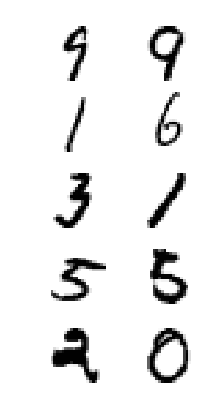

In [174]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

A teraz sprawdźmy etykiety (0 oznacza "różne", a 1 - "takie same"):

In [175]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

Znakomicie!

### 10.3.
_Ćwiczenie: wytrenuj sieć wobec zbioru uczącego. Dla każdej pary obrazów możesz jednocześnie przesyłać po jednym do sieci A i B. Cała sieć będzie stopniowo uczyła się rozpoznawać, czy pary obrazów należą do tej samej klasy._

Wygenerujmy zbiór testowy składający się z wielu par obrazów pochodzących z zestawu testowego MNIST:

In [176]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

Teraz zaś wytrenujmy model. Ten etap nie jest jakiś wyjątkowy oprócz faktu, że potrzebujemy całkiem dużej wartości parametru `batch_size`, gdyż w przeciwnym razie model nie nauczy się niczego i będzie uzyskiwać dokładność rzędu 50%:

In [177]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Funkcja straty dla zbioru testowego:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "Dokładność dla zbioru testowego:", acc_test)

    save_path = saver.save(sess, "./moj_model_porownywanie_cyfr.ckpt")

0 Train loss: 0.492426
0 Test accuracy: 0.7861
1 Train loss: 0.334813
2 Train loss: 0.290434
3 Train loss: 0.253434
4 Train loss: 0.217843
5 Train loss: 0.17127
5 Test accuracy: 0.9185
6 Train loss: 0.207128
7 Train loss: 0.172275
8 Train loss: 0.166783
9 Train loss: 0.161094
10 Train loss: 0.125131
10 Test accuracy: 0.9425
11 Train loss: 0.159824
12 Train loss: 0.124752
13 Train loss: 0.112234
14 Train loss: 0.114502
15 Train loss: 0.0950093
15 Test accuracy: 0.9532
16 Train loss: 0.119296
17 Train loss: 0.0754429
18 Train loss: 0.112295
19 Train loss: 0.133708
20 Train loss: 0.113547
20 Test accuracy: 0.9596
21 Train loss: 0.0674082
22 Train loss: 0.0936297
23 Train loss: 0.0986469
24 Train loss: 0.111875
25 Train loss: 0.0735623
25 Test accuracy: 0.9675
26 Train loss: 0.0790324
27 Train loss: 0.0487644
28 Train loss: 0.0869071
29 Train loss: 0.0694422
30 Train loss: 0.060089
30 Test accuracy: 0.9663
31 Train loss: 0.103902
32 Train loss: 0.0535952
33 Train loss: 0.0310679
34 Train l

W porządku, uzyskujemy dokładność rzędu 97,6% w tym zadaniu porównywania cyfr. Całkiem nieźle, model ten wie co nieco na temat porównywania odręcznie pisanych cyfr!

Sprawdźmy, czy ta wiedza może okazać się przydatna w standardowym zadaniu klasyfikacyjnym zestawu MNIST.

### 10.4.
_Ćwiczenie: stwórz teraz nową sieć GSN ponownie wykorzystując i zamrażając warstwy ukryte sieci A, a na szczycie wprowadzając dziesięcioneuronową warstwę wyjściową wykorzystującą funkcję softmax. Wyucz tę sieć wobec drugiego podzbioru danych i sprawdź, czy model jest w stanie osiągnąć wysoką wydajność pomimo faktu, że na każdą klasę przypada tylko 500 obrazów._

Stwórzmy model; nie powinno być to zadanie zbyt skomplikowane. Istnieje wiele metod zamrażania niższych warstw, co zostało opisane w książce. W tym przykładzie wybraliśmy funkcję `tf.stop_gradient()`. Zwróć uwagę, że potrzebujemy jednego obiektu `Saver` do odtwarzania gotowej sieci GSN A, a drugiego do zapisania ostatecznego modelu:

In [178]:
reset_graph()

n_inputs = 28 * 28  # Zbiór MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="GSN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="strata")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="GSN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

Czas na uczenie! Najpierw inicjujemy wszystkie zmienne (również stanowiące część nowej warstwy wyjściowej), po czym odtwarzamy gotową sieć GSN A. Następnie pozostaje nam wytrenować model na małym zbiorze danych MNIS (zawierającym zaledwie 5 000 obrazów): 

In [179]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./moj_model_porownywanie_cyfr.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Dokładność dla zbioru testowego:", acc_test)

    save_path = saver.save(sess, "./moj_ostateczny_model_mnist.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 Test accuracy: 0.9269
10 Test accuracy: 0.9675
20 Test accuracy: 0.9673
30 Test accuracy: 0.9673
40 Test accuracy: 0.9674
50 Test accuracy: 0.9673
60 Test accuracy: 0.9673
70 Test accuracy: 0.9673
80 Test accuracy: 0.9672
90 Test accuracy: 0.9673


Dokładność rzędu 96,7% to nie jest najlepszy wynik, jaki udało nam się do tej pory uzyskać dla zbioru MNIST, pamiętaj jednak, że korzystamy z niewielkiej liczby próbek uczących (zaledwie 500 obrazów na każdą cyfrę). Porównajmy ten rezultat z głęboką siecią neuronową wyuczoną od podstaw, bez korzytania z uczenia transferowego:

In [180]:
reset_graph()

n_inputs = 28 * 28  # zbiór MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="GSN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="strata")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="GSN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [181]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Dokładność dla zbioru testowego:", acc_test)

    save_path = saver.save(sess, "./moj_ostateczny_model_mnist.ckpt")

0 Test accuracy: 0.8893
10 Test accuracy: 0.9402
20 Test accuracy: 0.9479
30 Test accuracy: 0.9474
40 Test accuracy: 0.9479
50 Test accuracy: 0.9475
60 Test accuracy: 0.9475
70 Test accuracy: 0.9475
80 Test accuracy: 0.9476
90 Test accuracy: 0.9476
100 Test accuracy: 0.9473
110 Test accuracy: 0.9472
120 Test accuracy: 0.9474
130 Test accuracy: 0.9474
140 Test accuracy: 0.9475


Zaledwie 94,8% dokładności... Zatem uczenie transferowe pomogło nam zredukować stopę błędu z 5,2% do 3,3% (to zmniejszenie liczby pojawiających się błędów o ponad 36%). Do tego model wykorzystujący uczenie transferowe uzyskał dokładność rzędu 96% w ciągu dziesięciu epok.

Podsumowując, uczenie transferowe nie zawsze okazuje się skuteczne (przekonaliśmy się o tym w rozdziale 9.), ale z drugiej strony w odpowiednich sytuacjach potrafi zrobić dużą różnicę. Warto więc ją wypróbować!